In [8]:
import random

def get_all_strategies(S, N):
    """
    get a list of all pure strategies (x1, x2, ..., xN)
    with sum(xi)=S, xi>=0
    """
    results = []
    def back(nowSourceList, leftSource, slots):
        if slots == 1:
            results.append(tuple(nowSourceList + [leftSource]))
            return
        for i in range(leftSource+1):
            back(nowSourceList + [i], leftSource - i, slots - 1)
    back([], S, N)
    return results

def payoff_A_vs_B(strategyA, strategyB):
    """
    Colonel Blotto payoff: if a>b => (A+=1,B+=0);
                           if a<b => (A+=0,B+=1);
                           if a=b => each +=0.5.
    """
    scoreA = 0
    scoreB = 0
    for (a, b) in zip(strategyA, strategyB):
        if a > b:
            scoreA += 1
        elif a < b:
            scoreB += 1
        else:
            scoreA += 0.5
            scoreB += 0.5
    return scoreA, scoreB

def regret_matching_update(regretSum, strategies, chosenIndex, oppStrategy):
    """
    External regret update for time t:
      chosenIndex => the strategy we actually used
      oppStrategy => the opponent's actual strategy (tuple).
    """
    chosenStrat = strategies[chosenIndex]
    scoreChosen, _ = payoff_A_vs_B(chosenStrat, oppStrategy)

    for i, stratSprime in enumerate(strategies):
        score_sprime, _ = payoff_A_vs_B(stratSprime, oppStrategy)
        diff = score_sprime - scoreChosen
        regretSum[i] += diff
    return regretSum

def get_mixed_strategy_from_regret(regretSum):
    """
    p[i] = max(0, regret[i]) / sum_of_positives
    if all non-positive => uniform.
    """
    positives = [max(0.0, r) for r in regretSum]
    totalPos  = sum(positives)
    n = len(regretSum)
    if totalPos>1e-15:
        return [p/totalPos for p in positives]
    else:
        return [1.0/n]*n

def sample_from_distribution(dist):
    r = random.random()
    cum = 0.0
    for i, p in enumerate(dist):
        cum += p
        if r<cum:
            return i
    return len(dist)-1  # fallback

# ============ NE 检查需要: payoff 矩阵 & 检测函数 ============

def build_payoff_matrices(strategies):
    """
    A[i][j] = payoff of row player(A) if A= i, B= j
    B[i][j] = payoff of col player(B) if A= i, B= j
    """
    n = len(strategies)
    A = [[0.0]*n for _ in range(n)]
    B = [[0.0]*n for _ in range(n)]
    for i, sa in enumerate(strategies):
        for j, sb in enumerate(strategies):
            scoreA, scoreB = payoff_A_vs_B(sa, sb)
            A[i][j] = scoreA
            B[i][j] = scoreB
    return A, B

def check_NE(A, B, p, q, epsilon=1e-5):
    """
    检查( p, q )是否为(近似)混合纳什均衡：
    对 A: U_A(p, q) >= U_A(i, q), 对所有纯策略 i
          并对于 i in support(p), U_A(i,q) ~ U_A(p,q)
    对 B: 同理
    A[i][j], B[i][j]: payoff matrices, shape n x n
    p, q: length n
    """
    n = len(A)
    # 先算 UA(p,q), UB(p,q)
    UA_pq = 0.0
    UB_pq = 0.0
    for i in range(n):
        for j in range(n):
            UA_pq += p[i]*q[j]*A[i][j]
            UB_pq += p[i]*q[j]*B[i][j]

    # 对A: check pure strategy i
    for i in range(n):
        # U_A(i,q) = sum_j q[j]*A[i][j]
        U_iq = sum(q[j]*A[i][j] for j in range(n))
        if U_iq>UA_pq+epsilon:
            print(f"[A can deviate]: pure {i} => payoff={U_iq:.3f} > UA_pq={UA_pq:.3f}")
            return False
        # 若 p[i]>0 => check ~equal
        if p[i]>epsilon:
            if abs(U_iq - UA_pq)>5e-3:
                print(f"[A support mismatch]: i={i}, payoff(i,q)={U_iq:.3f}, UA_pq={UA_pq:.3f}")
                return False

    # 对B
    for j in range(n):
        # U_B(p,j) = sum_i p[i]*B[i][j]
        U_pj = sum(p[i]*B[i][j] for i in range(n))
        if U_pj>UB_pq+epsilon:
            print(f"[B can deviate]: pure {j} => payoff={U_pj:.3f} > UB_pq={UB_pq:.3f}")
            return False
        if q[j]>epsilon:
            if abs(U_pj - UB_pq)>5e-3:
                print(f"[B support mismatch]: j={j}, payoff(p,j)={U_pj:.3f}, UB_pq={UB_pq:.3f}")
                return False

    # 如果都没找到可偏离 => 近似NE
    print("=> (p,q) is a near Nash Equilibrium.")
    return True


# ===============  主函数  =================

def main():
    random.seed()
    S = 5
    N = 3
    num_iterations = 200000

    # 1) 枚举纯策略
    allStrategies = get_all_strategies(S, N)
    numStrats = len(allStrategies)
    print(f"we have {numStrats} pure strategies.")
    #for idx, st in enumerate(allStrategies):
    #    print(f"  ID={idx:2d} -> {st}")

    # 2) 初始化
    regretSumA = [0.0]*numStrats
    regretSumB = [0.0]*numStrats
    strategyA  = [1.0/numStrats]*numStrats
    strategyB  = [1.0/numStrats]*numStrats

    # 用于时间平均分布
    strategyCountA = [0.0]*numStrats
    strategyCountB = [0.0]*numStrats

    # 3) 迭代: 后悔匹配
    for t in range(1, num_iterations+1):
        # a) 抽样得到纯策略 iA, iB
        iA = sample_from_distribution(strategyA)
        iB = sample_from_distribution(strategyB)
        stratA = allStrategies[iA]
        stratB = allStrategies[iB]

        # b) 更新后悔
        regretSumA = regret_matching_update(regretSumA, allStrategies, iA, stratB)
        regretSumB = regret_matching_update(regretSumB, allStrategies, iB, stratA)

        # c) 得到新的混合策略
        strategyA = get_mixed_strategy_from_regret(regretSumA)
        strategyB = get_mixed_strategy_from_regret(regretSumB)

        # d) accumulate time-average
        for i in range(numStrats):
            strategyCountA[i] += strategyA[i]
            strategyCountB[i] += strategyB[i]

        # 观察中间
        if t%50000==0:
            print(f"After {t} iterations:")
            print("  strategyA =", [round(x,3) for x in strategyA])
            print("  strategyB =", [round(x,3) for x in strategyB])
            print()

    # 4) 得到“时间平均”混合策略
    finalA = [x/num_iterations for x in strategyCountA]
    finalB = [x/num_iterations for x in strategyCountB]

    print("\ntrain finish")
    print("the distribution of A in strategy ~ (prob>0.01)")
    for i, p in enumerate(finalA):
        if p>0.01:
            print(f"  ID={i}, strat={allStrategies[i]}, prob={p:.3f}")
    print("the distribution of B in strategy ~ (prob>0.01)")
    for i, p in enumerate(finalB):
        if p>0.01:
            print(f"  ID={i}, strat={allStrategies[i]}, prob={p:.3f}")

    # 5) 做一次实验对战
    test_rounds = 10000
    winsA = 0.0
    winsB = 0.0
    for _ in range(test_rounds):
        iA = sample_from_distribution(finalA)
        iB = sample_from_distribution(finalB)
        (a_score, b_score) = payoff_A_vs_B(allStrategies[iA], allStrategies[iB])
        if a_score > b_score:
            winsA += 1
        elif a_score < b_score:
            winsB += 1
        else:
            winsA += 0.5
            winsB += 0.5

    print(f"\nUsing {test_rounds} random matches:")
    print(f"  A total score：{winsA:.1f}")
    print(f"  B total score：{winsB:.1f}")
    if abs(winsA - winsB) < 1e-5:
        print("  => tie!")
    elif winsA > winsB:
        print("  => A wins more often")
    else:
        print("  => B wins more often")

    # ============ NE 检查部分 ===================
    # 首先构造 payoff 矩阵
    A_mat, B_mat = build_payoff_matrices(allStrategies)
    # 然后对 (finalA, finalB) 做 NE 检测
    print("\nNow check if (finalA, finalB) is a near NE:\n")
    is_NE = check_NE(A_mat, B_mat, finalA, finalB, epsilon=1e-1)
    if not is_NE:
        print("Conclusion: Not NE (or fails check_NE).")
    else:
        print("Conclusion: This is an approximate NE.\n")

if __name__=='__main__':
    main()


we have 21 pure strategies.
After 50000 iterations:
  strategyA = [0.0, 0.0, 0.124, 0.253, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.32, 0.297, 0.006, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.382, 0.0, 0.0, 0.0, 0.0, 0.0, 0.515, 0.0, 0.0, 0.0, 0.0, 0.103, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 100000 iterations:
  strategyA = [0.0, 0.0, 0.009, 0.0, 0.0, 0.0, 0.0, 0.135, 0.0, 0.0, 0.0, 0.169, 0.0, 0.0, 0.0, 0.108, 0.326, 0.253, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.337, 0.182, 0.0, 0.0, 0.0, 0.199, 0.0, 0.236, 0.0, 0.0, 0.0, 0.0, 0.046, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 150000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0, 0.004, 0.0, 0.0, 0.187, 0.164, 0.361, 0.255, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.229, 0.0, 0.402, 0.0, 0.0, 0.207, 0.162, 0.0, 0.0, 0.0, 0.0, 0.0]

After 200000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.041, 0.0, 0.0, 0.0, 0.0, 0.0, 0.203, 0.0, 0.0, 0.0, 0.0, 0.256

We have 21 pure strategies for S=5,N=3, in zero-sum version(tie=0).

--- Final average regrets (last few) ---
  t=1995, avg_regret_A=0.032080
  t=1996, avg_regret_A=0.032565
  t=1997, avg_regret_A=0.032549
  t=1998, avg_regret_A=0.032533
  t=1999, avg_regret_A=0.033017
  t=2000, avg_regret_A=0.033000


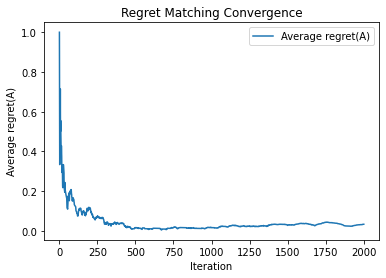


Check if empirical jointDist is CE:
[A violates CE]: i=2, i'=3, diff=0.118
Conclusion: Not CE.

Some (i,j) with prob>0.01 in jointDist:
   (i=2, j=9), prob=0.013, (A strat=(0, 2, 3), B strat=(1, 3, 1))
   (i=2, j=11), prob=0.015, (A strat=(0, 2, 3), B strat=(2, 0, 3))
   (i=2, j=14), prob=0.021, (A strat=(0, 2, 3), B strat=(2, 3, 0))
   (i=2, j=15), prob=0.018, (A strat=(0, 2, 3), B strat=(3, 0, 2))
   (i=2, j=16), prob=0.024, (A strat=(0, 2, 3), B strat=(3, 1, 1))
   (i=2, j=17), prob=0.019, (A strat=(0, 2, 3), B strat=(3, 2, 0))
   (i=3, j=2), prob=0.013, (A strat=(0, 3, 2), B strat=(0, 2, 3))
   (i=3, j=3), prob=0.017, (A strat=(0, 3, 2), B strat=(0, 3, 2))
   (i=3, j=9), prob=0.022, (A strat=(0, 3, 2), B strat=(1, 3, 1))
   (i=3, j=14), prob=0.014, (A strat=(0, 3, 2), B strat=(2, 3, 0))
   (i=7, j=11), prob=0.021, (A strat=(1, 1, 3), B strat=(2, 0, 3))
   (i=7, j=14), prob=0.013, (A strat=(1, 1, 3), B strat=(2, 3, 0))
   (i=7, j=15), prob=0.021, (A strat=(1, 1, 3), B strat=(3, 0, 

In [25]:
#检查CE和后悔值
import random
import math

def get_all_strategies(S, N):
    """
    返回所有将 S 个士兵分配到 N 个战场的纯策略列表。
    (x1, x2, ..., xN) with sum(xi)=S, xi>=0.
    """
    results = []
    def back(now, left, slots):
        if slots==1:
            results.append(tuple(now+[left]))
            return
        for i in range(left+1):
            back(now+[i], left-i, slots-1)
    back([], S, N)
    return results

def payoff_A_vs_B_zero_sum(strategyA, strategyB):
    """
    零和规则: 
      if a>b => (A=1,B=-1)
      if a<b => (A=-1,B=1)
      if a=b => (A=0,B=0)
    累加 3 个战场 => (scoreA, scoreB).
    """
    scoreA = 0
    scoreB = 0
    for (a, b) in zip(strategyA, strategyB):
        if a > b:
            scoreA += 1
            scoreB -= 1
        elif a < b:
            scoreA -= 1
            scoreB += 1
        else:
            pass
    return scoreA, scoreB

def regret_matching_update(regretSum, strategies, chosenIndex, oppStrategy):
    """
    对行玩家(A)或列玩家(B)来说: 
    chosenIndex => 当前用的纯策略
    oppStrategy => 对手用的具体纯策略(元组)
    累加 external regret: for each i,
      regretSum[i] += (score_i - score_chosen).
    """
    chosenStrat = strategies[chosenIndex]
    scoreChosen, _ = payoff_A_vs_B_zero_sum(chosenStrat, oppStrategy)
    for i, s_i in enumerate(strategies):
        score_i, _ = payoff_A_vs_B_zero_sum(s_i, oppStrategy)
        diff = score_i - scoreChosen
        regretSum[i] += diff
    return regretSum

def get_mixed_strategy_from_regret(regretSum):
    """
    p[i] = max(0, regretSum[i])/ sum_of_positives
    若 sum_of_positives=0 => 均匀分布
    """
    positives = [max(r,0) for r in regretSum]
    totalPos = sum(positives)
    n = len(regretSum)
    if totalPos>1e-15:
        return [p/totalPos for p in positives]
    else:
        return [1.0/n]*n

def sample_from_distribution(dist):
    r = random.random()
    cum = 0.0
    for i, p in enumerate(dist):
        cum += p
        if r<cum:
            return i
    return len(dist)-1

# ===========  构造 payoff 矩阵 for CE check  ===========

def build_payoff_matrices(strategies):
    """
    A[i][j] = 当 A 用 i, B 用 j 时, A的收益
    B[i][j] = 当 A 用 i, B 用 j 时, B的收益 = -A[i][j], 因为零和
    """
    n = len(strategies)
    A = [[0]*n for _ in range(n)]
    B = [[0]*n for _ in range(n)]
    for i, sa in enumerate(strategies):
        for j, sb in enumerate(strategies):
            scoreA, scoreB = payoff_A_vs_B_zero_sum(sa, sb)
            A[i][j] = scoreA
            B[i][j] = scoreB
    return A,B

# ===========  CE 检查 ===========

def check_CE(A, B, jointDist, epsilon=1e-9):
    """
    检查给定(A,B)收益矩阵, jointDist(联合分布) 是否近似CE.
    A,B形状均 n x n, jointDist同理, sum=1.
    """
    n = len(A)
    # 1) 行玩家(A)条件收益
    for i in range(n):
        mu_i = sum(jointDist[i][j] for j in range(n))
        if mu_i<epsilon: 
            continue
        old_payoff = 0.0
        for j in range(n):
            old_payoff += jointDist[i][j]*A[i][j]
        old_payoff /= mu_i
        for i_prime in range(n):
            if i_prime==i: 
                continue
            new_payoff=0.0
            for j in range(n):
                new_payoff += jointDist[i][j]*A[i_prime][j]
            new_payoff/=mu_i
            if new_payoff>old_payoff+epsilon:
                print(f"[A violates CE]: i={i}, i'={i_prime}, diff={new_payoff-old_payoff:.3f}")
                return False
    # 2) 列玩家(B)条件收益
    for j in range(n):
        mu_j = sum(jointDist[i][j] for i in range(n))
        if mu_j<epsilon:
            continue
        old_payoff = 0.0
        for i in range(n):
            old_payoff += jointDist[i][j]*B[i][j]
        old_payoff/= mu_j
        for j_prime in range(n):
            if j_prime==j: 
                continue
            new_payoff=0.0
            for i in range(n):
                new_payoff += jointDist[i][j]*B[i][j_prime]
            new_payoff/=mu_j
            if new_payoff>old_payoff+epsilon:
                print(f"[B violates CE]: j={j}, j'={j_prime}, diff={new_payoff-old_payoff:.3f}")
                return False
    print("=> jointDist satisfies (approx) CE condition.")
    return True

# ===========  主函数: 无悔学习+收敛速度表  ===========

def main():
    random.seed(1)
    S=5
    N=3
    allStrats = get_all_strategies(S,N)    # 生成纯策略
    m = len(allStrats)                    # ~21
    print(f"We have {m} pure strategies for S={S},N={N}, in zero-sum version(tie=0).")

    # payoff 矩阵
    A_mat, B_mat = build_payoff_matrices(allStrats)
    # B_mat 应该= -A_mat, 在 build时自动算了 (scoreB= -scoreA or 0)
    # 这里是tie=0, a>b =>(1,-1), a<b =>(-1,1).

    # 后悔值
    regretSumA = [0.0]*m
    regretSumB = [0.0]*m
    strategyA = [1.0/m]*m
    strategyB = [1.0/m]*m

    # 记录 (iA,iB) 出现频率 => 检查CE
    jointCount = [[0]*m for _ in range(m)]

    num_iters = 2000
    # 记录收敛速度: average regret(对A)
    regret_list = []

    for t in range(1, num_iters+1):
        # 1) 从当前混合策略采样
        iA = sample_from_distribution(strategyA)
        iB = sample_from_distribution(strategyB)
        # 2) 更新后悔
        stratA = allStrats[iA]
        stratB = allStrats[iB]
        regretSumA = regret_matching_update(regretSumA, allStrats, iA, stratB)
        regretSumB = regret_matching_update(regretSumB, allStrats, iB, stratA)
        # 3) 得到新的混合
        strategyA = get_mixed_strategy_from_regret(regretSumA)
        strategyB = get_mixed_strategy_from_regret(regretSumB)
        # 4) jointCount
        jointCount[iA][iB]+=1

        # === 计算 "平均外部后悔" for A ===
        # external regret for A:  max_{i'} regretSumA[i'] 的正部分
        max_regret_A = max(regretSumA)  # 可能有负值
        if max_regret_A < 0:
            max_regret_A = 0
        avg_regret_A = max_regret_A / t
        regret_list.append(avg_regret_A)

        # 可以每隔一定步数打印一次
        if t%5000000==0:
            print(f"Iter={t}, avg_regret_A={avg_regret_A:.5f}")

    # 最终 jointDist
    jointDist = [[ jointCount[i][j]/num_iters for j in range(m)] for i in range(m)]

    # 打印收敛速度表(或画图)
    print("\n--- Final average regrets (last few) ---")
    for step in [num_iters-5, num_iters-4, num_iters-3, num_iters-2, num_iters-1, num_iters]:
        print(f"  t={step}, avg_regret_A={regret_list[step-1]:.6f}")

    # 如果想画图，可加 matplotlib:
    
    import matplotlib.pyplot as plt
    plt.plot(range(1,num_iters+1), regret_list, label='Average regret(A)')
    plt.xlabel('Iteration')
    plt.ylabel('Average regret(A)')
    plt.title('Regret Matching Convergence')
    plt.legend()
    plt.show()
    

    # ========== 最后做 CE 检验 ==========
    print("\nCheck if empirical jointDist is CE:")
    is_ce = check_CE(A_mat,B_mat, jointDist, epsilon=1e-2)
    if is_ce:
        print("Conclusion: It's an approximate CE.\n")
    else:
        print("Conclusion: Not CE.\n")

    # 展示几项 jointDist>0.01
    print("Some (i,j) with prob>0.01 in jointDist:")
    for i in range(m):
        for j in range(m):
            if jointDist[i][j]>0.01:
                print(f"   (i={i}, j={j}), prob={jointDist[i][j]:.3f}, (A strat={allStrats[i]}, B strat={allStrats[j]})")

if __name__=="__main__":
    main()


We have 21 pure strategies for S=5,N=3, in zero-sum version(tie=0).
Iter=50000, avg_regret_A=0.00318
Iter=100000, avg_regret_A=0.00246
Iter=150000, avg_regret_A=0.00195
Iter=200000, avg_regret_A=0.00208
Iter=250000, avg_regret_A=0.00138
Iter=300000, avg_regret_A=0.00082

--- Final average regrets (last few) ---
  t=299995, avg_regret_A=0.000830
  t=299996, avg_regret_A=0.000827
  t=299997, avg_regret_A=0.000823
  t=299998, avg_regret_A=0.000827
  t=299999, avg_regret_A=0.000827
  t=300000, avg_regret_A=0.000823


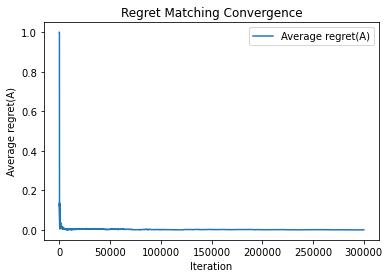


Check if empirical jointDist is CE:
[A violates CE]: i=2, i'=7, diff=0.031
Conclusion: Not CE.

Some (i,j) with prob>0.01 in jointDist:
   (i=2, j=2), prob=0.012, (A strat=(0, 2, 3), B strat=(0, 2, 3))
   (i=2, j=3), prob=0.013, (A strat=(0, 2, 3), B strat=(0, 3, 2))
   (i=2, j=7), prob=0.017, (A strat=(0, 2, 3), B strat=(1, 1, 3))
   (i=2, j=9), prob=0.012, (A strat=(0, 2, 3), B strat=(1, 3, 1))
   (i=2, j=11), prob=0.015, (A strat=(0, 2, 3), B strat=(2, 0, 3))
   (i=2, j=14), prob=0.012, (A strat=(0, 2, 3), B strat=(2, 3, 0))
   (i=2, j=15), prob=0.014, (A strat=(0, 2, 3), B strat=(3, 0, 2))
   (i=2, j=16), prob=0.011, (A strat=(0, 2, 3), B strat=(3, 1, 1))
   (i=3, j=2), prob=0.013, (A strat=(0, 3, 2), B strat=(0, 2, 3))
   (i=3, j=3), prob=0.013, (A strat=(0, 3, 2), B strat=(0, 3, 2))
   (i=3, j=7), prob=0.015, (A strat=(0, 3, 2), B strat=(1, 1, 3))
   (i=3, j=11), prob=0.012, (A strat=(0, 3, 2), B strat=(2, 0, 3))
   (i=3, j=15), prob=0.015, (A strat=(0, 3, 2), B strat=(3, 0, 2))

In [27]:
#检查CE和后悔值
import random
import math

def get_all_strategies(S, N):
    """
    返回所有将 S 个士兵分配到 N 个战场的纯策略列表。
    (x1, x2, ..., xN) with sum(xi)=S, xi>=0.
    """
    results = []
    def back(now, left, slots):
        if slots==1:
            results.append(tuple(now+[left]))
            return
        for i in range(left+1):
            back(now+[i], left-i, slots-1)
    back([], S, N)
    return results

def payoff_A_vs_B_zero_sum(strategyA, strategyB):
    """
    零和规则: 
      if a>b => (A=1,B=-1)
      if a<b => (A=-1,B=1)
      if a=b => (A=0,B=0)
    累加 3 个战场 => (scoreA, scoreB).
    """
    scoreA = 0
    scoreB = 0
    for (a, b) in zip(strategyA, strategyB):
        if a > b:
            scoreA += 1
            scoreB -= 1
        elif a < b:
            scoreA -= 1
            scoreB += 1
        else:
            pass
    return scoreA, scoreB

def regret_matching_update(regretSum, strategies, chosenIndex, oppStrategy):
    """
    对行玩家(A)或列玩家(B)来说: 
    chosenIndex => 当前用的纯策略
    oppStrategy => 对手用的具体纯策略(元组)
    累加 external regret: for each i,
      regretSum[i] += (score_i - score_chosen).
    """
    chosenStrat = strategies[chosenIndex]
    scoreChosen, _ = payoff_A_vs_B_zero_sum(chosenStrat, oppStrategy)
    for i, s_i in enumerate(strategies):
        score_i, _ = payoff_A_vs_B_zero_sum(s_i, oppStrategy)
        diff = score_i - scoreChosen
        regretSum[i] += diff
    return regretSum

def get_mixed_strategy_from_regret(regretSum):
    """
    p[i] = max(0, regretSum[i])/ sum_of_positives
    若 sum_of_positives=0 => 均匀分布
    """
    positives = [max(r,0) for r in regretSum]
    totalPos = sum(positives)
    n = len(regretSum)
    if totalPos>1e-15:
        return [p/totalPos for p in positives]
    else:
        return [1.0/n]*n

def sample_from_distribution(dist):
    r = random.random()
    cum = 0.0
    for i, p in enumerate(dist):
        cum += p
        if r<cum:
            return i
    return len(dist)-1

# ===========  构造 payoff 矩阵 for CE check  ===========

def build_payoff_matrices(strategies):
    """
    A[i][j] = 当 A 用 i, B 用 j 时, A的收益
    B[i][j] = 当 A 用 i, B 用 j 时, B的收益 = -A[i][j], 因为零和
    """
    n = len(strategies)
    A = [[0]*n for _ in range(n)]
    B = [[0]*n for _ in range(n)]
    for i, sa in enumerate(strategies):
        for j, sb in enumerate(strategies):
            scoreA, scoreB = payoff_A_vs_B_zero_sum(sa, sb)
            A[i][j] = scoreA
            B[i][j] = scoreB
    return A,B

# ===========  CE 检查 ===========

def check_CE(A, B, jointDist, epsilon=1e-9):
    """
    检查给定(A,B)收益矩阵, jointDist(联合分布) 是否近似CE.
    A,B形状均 n x n, jointDist同理, sum=1.
    """
    n = len(A)
    # 1) 行玩家(A)条件收益
    for i in range(n):
        mu_i = sum(jointDist[i][j] for j in range(n))
        if mu_i<epsilon: 
            continue
        old_payoff = 0.0
        for j in range(n):
            old_payoff += jointDist[i][j]*A[i][j]
        old_payoff /= mu_i
        for i_prime in range(n):
            if i_prime==i: 
                continue
            new_payoff=0.0
            for j in range(n):
                new_payoff += jointDist[i][j]*A[i_prime][j]
            new_payoff/=mu_i
            if new_payoff>old_payoff+epsilon:
                print(f"[A violates CE]: i={i}, i'={i_prime}, diff={new_payoff-old_payoff:.3f}")
                return False
    # 2) 列玩家(B)条件收益
    for j in range(n):
        mu_j = sum(jointDist[i][j] for i in range(n))
        if mu_j<epsilon:
            continue
        old_payoff = 0.0
        for i in range(n):
            old_payoff += jointDist[i][j]*B[i][j]
        old_payoff/= mu_j
        for j_prime in range(n):
            if j_prime==j: 
                continue
            new_payoff=0.0
            for i in range(n):
                new_payoff += jointDist[i][j]*B[i][j_prime]
            new_payoff/=mu_j
            if new_payoff>old_payoff+epsilon:
                print(f"[B violates CE]: j={j}, j'={j_prime}, diff={new_payoff-old_payoff:.3f}")
                return False
    print("=> jointDist satisfies (approx) CE condition.")
    return True

# ===========  主函数: 无悔学习+收敛速度表  ===========

def main():
    random.seed()
    S=5
    N=3
    allStrats = get_all_strategies(S,N)    # 生成纯策略
    m = len(allStrats)                    # ~21
    print(f"We have {m} pure strategies for S={S},N={N}, in zero-sum version(tie=0).")

    # payoff 矩阵
    A_mat, B_mat = build_payoff_matrices(allStrats)
    # B_mat 应该= -A_mat, 在 build时自动算了 (scoreB= -scoreA or 0)
    # 这里是tie=0, a>b =>(1,-1), a<b =>(-1,1).

    # 后悔值
    regretSumA = [0.0]*m
    regretSumB = [0.0]*m
    strategyA = [1.0/m]*m
    strategyB = [1.0/m]*m

    # 记录 (iA,iB) 出现频率 => 检查CE
    jointCount = [[0]*m for _ in range(m)]

    num_iters = 300000
    # 记录收敛速度: average regret(对A)
    regret_list = []

    for t in range(1, num_iters+1):
        # 1) 从当前混合策略采样
        iA = sample_from_distribution(strategyA)
        iB = sample_from_distribution(strategyB)
        # 2) 更新后悔
        stratA = allStrats[iA]
        stratB = allStrats[iB]
        regretSumA = regret_matching_update(regretSumA, allStrats, iA, stratB)
        regretSumB = regret_matching_update(regretSumB, allStrats, iB, stratA)
        # 3) 得到新的混合
        strategyA = get_mixed_strategy_from_regret(regretSumA)
        strategyB = get_mixed_strategy_from_regret(regretSumB)
        # 4) jointCount
        jointCount[iA][iB]+=1

        # === 计算 "平均外部后悔" for A ===
        # external regret for A:  max_{i'} regretSumA[i'] 的正部分
        max_regret_A = max(regretSumA)  # 可能有负值
        if max_regret_A < 0:
            max_regret_A = 0
        avg_regret_A = max_regret_A / t
        regret_list.append(avg_regret_A)

        # 可以每隔一定步数打印一次
        if t%50000==0:
            print(f"Iter={t}, avg_regret_A={avg_regret_A:.5f}")

    # 最终 jointDist
    jointDist = [[ jointCount[i][j]/num_iters for j in range(m)] for i in range(m)]

    # 打印收敛速度表(或画图)
    print("\n--- Final average regrets (last few) ---")
    for step in [num_iters-5, num_iters-4, num_iters-3, num_iters-2, num_iters-1, num_iters]:
        print(f"  t={step}, avg_regret_A={regret_list[step-1]:.6f}")

    # 如果想画图，可加 matplotlib:
    
    import matplotlib.pyplot as plt
    plt.plot(range(1,num_iters+1), regret_list, label='Average regret(A)')
    plt.xlabel('Iteration')
    plt.ylabel('Average regret(A)')
    plt.title('Regret Matching Convergence')
    plt.legend()
    plt.show()
    

    # ========== 最后做 CE 检验 ==========
    print("\nCheck if empirical jointDist is CE:")
    is_ce = check_CE(A_mat,B_mat, jointDist, epsilon=1e-2)
    if is_ce:
        print("Conclusion: It's an approximate CE.\n")
    else:
        print("Conclusion: Not CE.\n")

    # 展示几项 jointDist>0.01
    print("Some (i,j) with prob>0.01 in jointDist:")
    for i in range(m):
        for j in range(m):
            if jointDist[i][j]>0.01:
                print(f"   (i={i}, j={j}), prob={jointDist[i][j]:.3f}, (A strat={allStrats[i]}, B strat={allStrats[j]})")

if __name__=="__main__":
    main()


In [38]:
#强化学习算法
import random

def get_all_strategies(S, N):
    """
    列举所有把 S 个兵力分配到 N 个战场的纯策略:
    返回一个列表, 列表里的每个元素是 (x1,x2,...,xN), sum= S, xi>=0.
    """
    results = []
    def back(now, left, slots):
        if slots==1:
            results.append(tuple(now+[left]))
            return
        for i in range(left+1):
            back(now+[i], left-i, slots-1)
    back([], S, N)
    return results

def payoff_blotto(strategyA, strategyB):
    """
    (N=3) Colonel Blotto计分:
      战场i: if A_i> B_i => A得1分; A_i< B_i => B得1分; 相等 => 各0.5
    返回 (scoreA, scoreB).
    """
    scoreA, scoreB = 0.0, 0.0
    for a, b in zip(strategyA, strategyB):
        if a > b:
            scoreA += 1
        elif a < b:
            scoreB += 1
        else:
            scoreA += 0.5
            scoreB += 0.5
    return (scoreA, scoreB)

def epsilon_greedy(Q, epsilon):
    """
    在 Q (list/array) 上做 epsilon-贪心:
      - 以 epsilon 的概率随机动作
      - 否则选 Q值最大的动作(如有并列, 随机选并列)
    返回选到的动作索引(0..len(Q)-1).
    """
    n = len(Q)
    if random.random()< epsilon:
        return random.randint(0, n-1)
    else:
        maxQ = max(Q)
        candidates = [i for i,qv in enumerate(Q) if qv == maxQ]
        return random.choice(candidates)

def q_learning_blotto(S=5, N=3, alpha=0.1, epsilon=0.1, episodes=200000):
    """
    在 (S=5, N=3) Colonel Blotto 中, 用Q-Learning让A,B都学习.
    返回 (Q1, Q2, actionsA, actionsB).

    - Q1[i]: 玩家A对动作 i 的Q值
    - Q2[j]: 玩家B对动作 j 的Q值
    - actionsA, actionsB: 动作列表(本例中相同,各= get_all_strategies(S,N))
    """
    # 1) 枚举动作(兵力分配)
    actionsA = get_all_strategies(S,N)  # len= C(S+N-1, N-1)
    actionsB = actionsA  # 假设对称(都 S=5,N=3)
    nA = len(actionsA)
    nB = len(actionsB)

    # 2) 初始化 Q表
    Q1 = [0.0]*nA   # A 的 Q 值
    Q2 = [0.0]*nB   # B 的 Q 值

    for episode in range(1, episodes+1):
        # a) A,B 各用 epsilon_greedy 从各自Q里选动作
        iA = epsilon_greedy(Q1, epsilon)  # A的动作索引
        iB = epsilon_greedy(Q2, epsilon)  # B的动作索引
        stratA = actionsA[iA]
        stratB = actionsB[iB]

        # b) 得到奖励
        rA, rB = payoff_blotto(stratA, stratB)

        # c) 更新Q: Q(a) = Q(a) + alpha*(r- Q(a))   (无状态,下个状态不考虑)
        oldA = Q1[iA]
        oldB = Q2[iB]
        Q1[iA] = oldA + alpha*(rA - oldA)
        Q2[iB] = oldB + alpha*(rB - oldB)

        # d) 适当打印信息(可选)
        if episode%500000==0 and episode>0:
            epsilon/=2
            alpha/=2
            print(f"episode={episode}, iA={iA}, iB={iB}, rA={rA}, rB={rB}, "
                  f"Q1[{iA}]={Q1[iA]:.3f}, Q2[{iB}]={Q2[iB]:.3f}")

    return Q1, Q2, actionsA, actionsB

# ============ (可选) 构造 payoff 矩阵 & 检查 NE =============

def build_payoff_matrices(actions):
    """
    给定 actions(纯策略列表), 构造 A[i][j], B[i][j]:
      A[i][j]: A用动作i, B用动作j 时, A的收益
      B[i][j]: B的收益
    """
    n = len(actions)
    A = [[0]*n for _ in range(n)]
    B = [[0]*n for _ in range(n)]
    for i, a in enumerate(actions):
        for j, b in enumerate(actions):
            rA, rB = payoff_blotto(a, b)
            A[i][j] = rA
            B[i][j] = rB
    return A,B

def check_NE(A, B, p, q, epsilon=1e-5):
    """
    检查( p, q )是否是(近似)纳什均衡:
      - p,q: size=n,
      - A,B: n×n payoff matrix
    """
    n = len(A)
    # 1) 计算 U_A(p,q), U_B(p,q)
    UA_pq=0; UB_pq=0
    for i in range(n):
        for j in range(n):
            UA_pq += p[i]*q[j]*A[i][j]
            UB_pq += p[i]*q[j]*B[i][j]

    # 2) 对A
    for i in range(n):
        # U_A(i,q)
        U_iq = sum(q[j]*A[i][j] for j in range(n))
        if U_iq>UA_pq+epsilon:
            print(f"[A can deviate] i={i}, payoff_iq={U_iq:.3f}, UA_pq={UA_pq:.3f}")
            return False
        if p[i]>epsilon:
            if abs(U_iq-UA_pq)>1e-1:
                print(f"[A support mismatch] i={i}, payoff_iq={U_iq:.3f}, UA_pq={UA_pq:.3f}")
                return False
    # 3) 对B
    for j in range(n):
        U_pj = sum(p[i]*B[i][j] for i in range(n))
        if U_pj>UB_pq+epsilon:
            print(f"[B can deviate] j={j}, payoff_pj={U_pj:.3f}, UB_pq={UB_pq:.3f}")
            return False
        if q[j]>epsilon:
            if abs(U_pj-UB_pq)>1e-1:
                print(f"[B support mismatch] j={j}, payoff_pj={U_pj:.3f}, UB_pq={UB_pq:.3f}")
                return False

    print("=> (p,q) is a near NE.")
    return True

# =============== 主程序 ================
def main():
    random.seed()
    # 超参数
    S, N = 5, 3
    alpha = 0.1
    epsilon=0.1
    episodes=2000000

    print(f"Start Q-learning for Colonel Blotto with (S={S}, N={N}).")
    # 1) 运行 Q-Learning
    Q1, Q2, actionsA, actionsB = q_learning_blotto(S, N, alpha, epsilon, episodes)
    nA = len(actionsA)
    print(f"Number of actions = {nA}")

    # 2) 最后: 取 Q中最大的动作(纯策略) 并显示
    bestA = max(range(nA), key=lambda i: Q1[i])
    bestB = max(range(nA), key=lambda i: Q2[i])
    print("\n=== Learned Q ===")
    print("Q1=", [round(q,2) for q in Q1])
    print("Q2=", [round(q,2) for q in Q2])
    print(f"bestA={bestA}, Q1={Q1[bestA]:.2f}, strategy={actionsA[bestA]}")
    print(f"bestB={bestB}, Q2={Q2[bestB]:.2f}, strategy={actionsB[bestB]}")

    # 3) 若想用 Softmax/其他方式获得混合策略, 也可做:
    def softmax(Q, tau=0.01):
        import math
        exps = [math.exp(qv/tau) for qv in Q]
        s = sum(exps)
        return [e/s for e in exps]

    pA = softmax(Q1, tau=0.01)
    pB = softmax(Q2, tau=0.01)
    # 只显示概率>0.01
    print("\n=== Approx mixed strategies via softmax(Q/0.01) ===")
    for i, prob in enumerate(pA):
        if prob>0.01:
            print(f" A: action={i}, prob={prob:.3f}, {actionsA[i]}")
    for j, prob in enumerate(pB):
        if prob>0.01:
            print(f" B: action={j}, prob={prob:.3f}, {actionsB[j]}")

    # 4) 构造 payoff 矩阵, 做 NE 检查
    A_mat, B_mat = build_payoff_matrices(actionsA)  
    print("\nCheck if the softmax distribution is near NE:")
    is_ne = check_NE(A_mat, B_mat, pA, pB, epsilon=1e-1)
    if not is_ne:
        print("Conclusion: Not NE.")
    else:
        print("Conclusion: It's near NE.")

if __name__=="__main__":
    main()


Start Q-learning for Colonel Blotto with (S=5, N=3).
episode=500000, iA=2, iB=6, rA=1.0, rB=2.0, Q1[2]=1.439, Q2[6]=1.518
episode=1000000, iA=13, iB=14, rA=1.5, rB=1.5, Q1[13]=1.512, Q2[14]=1.501
episode=1500000, iA=8, iB=3, rA=1.5, rB=1.5, Q1[8]=1.501, Q2[3]=1.498
episode=2000000, iA=14, iB=3, rA=1.5, rB=1.5, Q1[14]=1.500, Q2[3]=1.500
Number of actions = 21

=== Learned Q ===
Q1= [1.21, 1.41, 1.45, 1.45, 1.44, 1.23, 1.4, 1.46, 1.45, 1.48, 1.41, 1.46, 1.48, 1.45, 1.5, 1.49, 1.48, 1.46, 1.39, 1.44, 1.19]
Q2= [1.15, 1.35, 1.47, 1.5, 1.39, 1.2, 1.39, 1.44, 1.46, 1.47, 1.4, 1.44, 1.46, 1.47, 1.48, 1.48, 1.49, 1.49, 1.43, 1.46, 1.23]
bestA=14, Q1=1.50, strategy=(2, 3, 0)
bestB=3, Q2=1.50, strategy=(0, 3, 2)

=== Approx mixed strategies via softmax(Q/0.01) ===
 A: action=7, prob=0.010, (1, 1, 3)
 A: action=9, prob=0.110, (1, 3, 1)
 A: action=11, prob=0.012, (2, 0, 3)
 A: action=12, prob=0.044, (2, 1, 2)
 A: action=14, prob=0.516, (2, 3, 0)
 A: action=15, prob=0.226, (3, 0, 2)
 A: action=16, 

In [39]:
import random
import math

def get_all_strategies(S, N):
    """
    返回所有将 S 个兵力分配到 N 个战场的纯策略列表 (tuple)。
    """
    results = []
    def backtrack(now, left, slots):
        if slots==1:
            results.append(tuple(now+[left]))
            return
        for i in range(left+1):
            backtrack(now+[i], left-i, slots-1)
    backtrack([], S, N)
    return results

def payoff_blotto(stratA, stratB):
    """
    (N=3) 兵力比大小: if a>b => A得1分; a<b => B得1分; a=b =>各0.5
    返回 (scoreA, scoreB).
    """
    scoreA, scoreB=0.0,0.0
    for a,b in zip(stratA, stratB):
        if a>b:
            scoreA+=1
        elif a<b:
            scoreB+=1
        else:
            scoreA+=0.5
            scoreB+=0.5
    return (scoreA, scoreB)

def softmax_selection(Q_row, tau=0.01):
    """
    Softmax 选动作: Q_row是 [Q(state,0), Q(state,1),..., Q(state,nActions-1)],
    返回动作索引.
    """
    exps = [math.exp(qv/tau) for qv in Q_row]
    s    = sum(exps)
    r    = random.random()*s
    cum  = 0.0
    for i, e in enumerate(exps):
        cum+=e
        if r<=cum:
            return i
    return len(Q_row)-1

def epsilon_greedy_selection(Q_row, epsilon=0.1):
    """
    epsilon 贪心: 以 epsilon 的概率随机，否则选Q最大的动作(并列随机)。
    """
    n = len(Q_row)
    if random.random()<epsilon:
        return random.randint(0,n-1)
    else:
        maxQ= max(Q_row)
        candidates = [i for i,qv in enumerate(Q_row) if qv==maxQ]
        return random.choice(candidates)

def q_learning_blotto_stateful(S=5, N=3, alpha=0.1, episodes=200_000, 
                               choose_method='softmax', tau=0.01, epsilon=0.1):
    """
    在 (S=5, N=3) Colonel Blotto 中做 "多状态" Q-Learning:
      状态= "对手上一回合动作索引"(取值0..nActions-1, + 特殊值-1 表示无历史).
    返回 (Q1, Q2, actions, nStates).
    """

    actions = get_all_strategies(S,N)
    nA = len(actions)
    # 状态空间=  nA +1(无历史=-1?)
    # 这里简化: 我们用 range(nA) + special -1. => total nA+1
    # 但为了方便数组索引, 我们做 "state=0..nA-1" + "state=nA 表示无历史"
    # => 所以 Q1, Q2 形状= (nA+1) x nA
    nStates = nA+1
    Q1 = [[0.0]*nA for _ in range(nStates)]  # Q1[state][actionA]
    Q2 = [[0.0]*nA for _ in range(nStates)]  # Q2[state][actionB]

    def select_action(Q_table, state):
        """ 根据 choose_method (softmax or eps-greedy) 选动作 """
        Q_row = Q_table[state]
        if choose_method=='softmax':
            return softmax_selection(Q_row, tau)
        else:
            return epsilon_greedy_selection(Q_row, epsilon)

    # 初始状态: stateA = nA, stateB=nA => 表示"无历史"
    stateA = nA
    stateB = nA

    # 训练 episodes 回
    for episode in range(1, episodes+1):
        # 1) A,B 各在自己的状态 (stateA, stateB) 下选动作
        iA = select_action(Q1, stateA)
        iB = select_action(Q2, stateB)

        # 2) 获得收益
        stratA = actions[iA]
        stratB = actions[iB]
        rA, rB = payoff_blotto(stratA, stratB)

        # 3) Q更新: Q(state,action) += alpha*(r - Q(state,action))
        oldQ1 = Q1[stateA][iA]
        oldQ2 = Q2[stateB][iB]
        Q1[stateA][iA] = oldQ1 + alpha*(rA - oldQ1)
        Q2[stateB][iB] = oldQ2 + alpha*(rB - oldQ2)

        # 4) 下一个状态: A的 stateA' = iB, B的 stateB'= iA
        nextStateA = iB
        nextStateB = iA

        # 5) 转移
        stateA = nextStateA
        stateB = nextStateB

        # 可选:debug
        # if episode%50000==0:
        #    print(f"episode={episode}, stateA={stateA}, iA={iA}, rA={rA}, Q1={Q1[stateA][iA]:.2f}")

    return Q1, Q2, actions

# =========== 对最终策略做说明并可检验 ===========

def main():
    random.seed(42)

    S,N=5,3
    alpha=0.1
    episodes=400000
    # 1) 先用softmax训练
    Q1_sf, Q2_sf, actions = q_learning_blotto_stateful(
        S=S, N=N, alpha=alpha, episodes=episodes, 
        choose_method='softmax', tau=0.01)

    # 2) 再用 eps-greedy 训练(对比)
    Q1_eps, Q2_eps, actions2= q_learning_blotto_stateful(
        S=S, N=N, alpha=alpha, episodes=episodes, 
        choose_method='eps-greedy', epsilon=0.1)

    nA = len(actions)
    print(f"Number of actions={nA} for S={S},N={N}. (Should be 21)")

    # 如果想查看 Q1_sf: shape=(nA+1) x nA
    # 最终你若对"某个 state(对手上次动作= iOpp)" => Q1_sf[iOpp], 再 softmax => 得到一个混合策略

    # 这里举例: 如果对手上次动作= iOpp=0, 我方的策略行= Q1_sf[0],
    # 用 softmax 变成概率分布:
    def softmax_probs(Q_row, tau=0.01):
        import math
        exps = [math.exp(qv/tau) for qv in Q_row]
        s= sum(exps)
        return [e/s for e in exps]

    # A: 查看对手上次动作 iOpp=0 -> A 的策略分布
    iOpp=0
    pA = softmax_probs(Q1_sf[iOpp], 0.01)
    # 只显示大于0.01概率的
    print(f"\n--- If Opp's last action= {iOpp}, A's distribution (softmax of Q1_sf[0]):")
    for iAction, pr in enumerate(pA):
        if pr>0.01:
            print(f"   Action i={iAction}, prob={pr:.3f}, {actions[iAction]}")

    # 如果想得到"总体策略", 在重复对局中可能要再加一个对手动作分布假设。

    # 这里就演示到此。你也可做 check_NE, 需先构造 payoff 矩阵 & 假设对手动作分布等。
    print("\nDone. We used multi-state Q-learning (based on last action) with softmax or eps-greedy.")

if __name__=="__main__":
    main()


Number of actions=21 for S=5,N=3. (Should be 21)

--- If Opp's last action= 0, A's distribution (softmax of Q1_sf[0]):
   Action i=5, prob=1.000, (0, 5, 0)

Done. We used multi-state Q-learning (based on last action) with softmax or eps-greedy.


In [2]:
#考虑对手行为的强化学习
import random
import math

def get_all_strategies(S, N):
    """
    列举所有把 S 个兵力分配到 N 个战场的纯策略:
    返回一个列表, 列表里的每个元素是 (x1,x2,...,xN), sum= S, xi>=0.
    """
    results = []
    def back(now, left, slots):
        if slots==1:
            results.append(tuple(now+[left]))
            return
        for i in range(left+1):
            back(now+[i], left-i, slots-1)
    back([], S, N)
    return results

def payoff_blotto(strategyA, strategyB):
    """
    (N=3) Colonel Blotto计分:
      战场i: if A_i> B_i => A得1分; A_i< B_i => B得1分; 相等 => 各0.5
    返回 (scoreA, scoreB).
    """
    scoreA, scoreB = 0.0, 0.0
    for a, b in zip(strategyA, strategyB):
        if a > b:
            scoreA += 1
        elif a < b:
            scoreB += 1
        else:
            scoreA += 0.5
            scoreB += 0.5
    return (scoreA, scoreB)

def epsilon_greedy(Q_row, epsilon):
    """
    在 Q_row(list/array) 上做 epsilon-贪心:
      - 以 epsilon 的概率随机动作(0..len(Q_row)-1)
      - 否则选 Q值最大的动作(如有并列, 随机选并列)
    返回选到的动作索引(0..len(Q_row)-1).
    """
    n = len(Q_row)
    if random.random()< epsilon:
        return random.randint(0, n-1)
    else:
        maxQ = max(Q_row)
        candidates = [i for i,qv in enumerate(Q_row) if qv == maxQ]
        return random.choice(candidates)


def q_learning_blotto_multi_state(S=5, N=3, alpha=0.1, epsilon=0.1, episodes=200000):
    """
    A,B 各自的状态 = "对手上一回合选的动作" (0..nActs-1),
    动作空间= nActs(=21).
    若是第一回合, 用一个特殊 state (nActs) 表示 "无历史".
    
    Q1[stateA][actionA], Q2[stateB][actionB].
    每回合:
      stateA = B上回合动作, stateB= A上回合动作
      A 用 epsilon_greedy(Q1[stateA]) 选 iA
      B 用 epsilon_greedy(Q2[stateB]) 选 iB
      payoff => rA,rB
      Q1[stateA][iA]+= alpha*(rA - oldQ)
      Q2[stateB][iB]+= alpha*(rB - oldQ)
      nextStateA= iB, nextStateB=iA
    """
    actions = get_all_strategies(S,N)  # 21 个动作
    nActs   = len(actions)
    # 状态数= nActs +1 (其中最后一个表示 "无历史" )
    nStates = nActs+1

    # 初始化 Q表: Q1, Q2 均 shape= (nStates x nActs)
    Q1 = [[0.0]*nActs for _ in range(nStates)]
    Q2 = [[0.0]*nActs for _ in range(nStates)]

    # 初始状态(无历史)
    stateA= nActs
    stateB= nActs

    for ep in range(1, episodes+1):
        # 1) 根据 stateA, stateB 选动作
        iA = epsilon_greedy(Q1[stateA], epsilon)
        iB = epsilon_greedy(Q2[stateB], epsilon)

        # 2) payoff
        stratA= actions[iA]
        stratB= actions[iB]
        rA, rB= payoff_blotto(stratA, stratB)

        # 3) 更新 Q
        oldQ1= Q1[stateA][iA]
        oldQ2= Q2[stateB][iB]
        Q1[stateA][iA] = oldQ1 + alpha*(rA - oldQ1)
        Q2[stateB][iB] = oldQ2 + alpha*(rB - oldQ2)

        # 4) 转移
        nextStateA= iB
        nextStateB= iA
        stateA= nextStateA
        stateB= nextStateB

        # (可选)每隔一段减少epsilon等
        if ep%50000==0:
            epsilon= max(0.01, epsilon*0.5)
            alpha= max(0.01, alpha*0.5)
            print(f"episode={ep}, stateA={stateA}, iA={iA}, rA={rA}, Q1={Q1[stateA][iA]:.2f}")
            # print( ... )

    return Q1, Q2, actions

def build_payoff_matrices(actions):
    """
    构造 payoff矩阵 A[i][j], B[i][j]:
      A[i][j]: A用 i, B用 j, A的得分
      B[i][j]: B的得分
    """
    n= len(actions)
    A= [[0]*n for _ in range(n)]
    B= [[0]*n for _ in range(n)]
    for i, a in enumerate(actions):
        for j, b in enumerate(actions):
            rA, rB= payoff_blotto(a,b)
            A[i][j]= rA
            B[i][j]= rB
    return A,B

def check_NE(A,B, p, q, epsilon=1e-5):
    """
    检查( p, q )是否(近似)纳什均衡:
       U_A(p,q)>= U_A(i,q), ∀i; 
       U_B(p,q)>= U_B(p,j), ∀j; 
       对支撑集中动作收益= UA(p,q) or UB(p,q).
    """
    n= len(A)
    # 先算 UA_pq, UB_pq
    UA_pq=0; UB_pq=0
    for i in range(n):
        for j in range(n):
            UA_pq+= p[i]*q[j]* A[i][j]
            UB_pq+= p[i]*q[j]* B[i][j]
    # A
    for i in range(n):
        U_iq= sum(q[j]*A[i][j] for j in range(n))
        if U_iq> UA_pq+epsilon:
            print(f"[A can deviate] i={i}, payoff_iq={U_iq:.3f} > UA_pq={UA_pq:.3f}")
            return False
        if p[i]>epsilon:
            if abs(U_iq-UA_pq)>1e-3:
                print(f"[A support mismatch] i={i}, payoff_iq={U_iq:.3f}, UA={UA_pq:.3f}")
                return False
    # B
    for j in range(n):
        U_pj= sum(p[i]*B[i][j] for i in range(n))
        if U_pj>UB_pq+epsilon:
            print(f"[B can deviate] j={j}, payoff_pj={U_pj:.3f} > UB_pq={UB_pq:.3f}")
            return False
        if q[j]>epsilon:
            if abs(U_pj-UB_pq)>1e-3:
                print(f"[B support mismatch] j={j}, payoff_pj={U_pj:.3f}, UB={UB_pq:.3f}")
                return False
    print("=> (p,q) is near NE.")
    return True

def main():
    random.seed()
    S,N=5,3
    alpha=0.1
    epsilon=0.1
    episodes=20000000

    print(f"Multi-state Q-Learning: S={S}, N={N}, episodes={episodes}")
    # 1) 运行多状态 Q-Learning
    Q1, Q2, actions= q_learning_blotto_multi_state(S,N, alpha,epsilon, episodes)
    nActs= len(actions)
    print(f"Number of actions= {nActs} (should be 21)")

    # 2) 在对战(执行)时, 仍需要 "stateA= B 上次动作, stateB= A 上次动作".
    # 但是若只想看看Q表: Q1[state][action], Q2[state][action].
    # 例如, 如果对手上一回合动作= iOpp=0, 我可以取 argmax(Q1[iOpp]) 之类。

    # 这里简单地: 取 "无历史" state= nActs 行 => 选 Q值最高的动作
    stateNoHist= nActs
    bestA= max(range(nActs), key=lambda a: Q1[stateNoHist][a])
    bestB= max(range(nActs), key=lambda b: Q2[stateNoHist][b])
    print(f"\nFrom 'no-history' state perspective, bestA= {bestA}, bestB= {bestB}")
    print(f"A strategy= {actions[bestA]}, B strategy= {actions[bestB]}")

    # 如果要构造 "混合策略" for "no-history" state,可做softmax:
    def softmax(Q_row, tau=0.01):
        exps= [math.exp(qv/tau) for qv in Q_row]
        s= sum(exps)
        return [e/s for e in exps]

    pA= softmax(Q1[stateNoHist], tau=0.01)
    pB= softmax(Q2[stateNoHist], tau=0.01)
    print("\nSoftmax distribution from 'no-history' state (prob>0.01):")
    for i,pr in enumerate(pA):
        if pr>0.01:
            print(f" A: i={i}, prob={pr:.3f}, {actions[i]}")
    for j,pr in enumerate(pB):
        if pr>0.01:
            print(f" B: j={j}, prob={pr:.3f}, {actions[j]}")

    # 3) 检测 (pA,pB) 是否近似 NE:
    # 构造 payoff matrix
    A_mat, B_mat= build_payoff_matrices(actions)
    print("\nCheck NE for the softmax distribution at 'no-history' state:")
    is_ne= check_NE(A_mat,B_mat, pA, pB, epsilon=1e-3)
    print("Conclusion:", "Is NE." if is_ne else "Not NE.")

if __name__=="__main__":。
    main()


Multi-state Q-Learning: S=5, N=3, episodes=20000000
episode=50000, stateA=2, iA=2, rA=1.5, Q1=1.19
episode=100000, stateA=7, iA=6, rA=1.5, Q1=0.53
episode=150000, stateA=10, iA=8, rA=1.5, Q1=1.16
episode=200000, stateA=3, iA=3, rA=1.5, Q1=1.06
episode=250000, stateA=12, iA=12, rA=1.5, Q1=1.38
episode=300000, stateA=12, iA=17, rA=2.0, Q1=1.50
episode=350000, stateA=11, iA=3, rA=1.0, Q1=1.43
episode=400000, stateA=8, iA=3, rA=1.5, Q1=1.35
episode=450000, stateA=15, iA=3, rA=1.5, Q1=1.50
episode=500000, stateA=3, iA=3, rA=1.5, Q1=1.16
episode=550000, stateA=14, iA=6, rA=1.0, Q1=1.30
episode=600000, stateA=14, iA=15, rA=2.0, Q1=1.50
episode=650000, stateA=3, iA=15, rA=1.5, Q1=1.27
episode=700000, stateA=15, iA=3, rA=1.5, Q1=1.48
episode=750000, stateA=15, iA=16, rA=1.5, Q1=1.28
episode=800000, stateA=1, iA=15, rA=1.0, Q1=1.27
episode=850000, stateA=17, iA=14, rA=1.5, Q1=1.42
episode=900000, stateA=1, iA=9, rA=2.0, Q1=1.52
episode=950000, stateA=14, iA=8, rA=1.0, Q1=1.37
episode=1000000, st

episode=8200000, stateA=7, iA=11, rA=1.5, Q1=1.48
episode=8250000, stateA=3, iA=2, rA=1.5, Q1=1.47
episode=8300000, stateA=15, iA=7, rA=2.0, Q1=1.51
episode=8350000, stateA=7, iA=9, rA=1.5, Q1=1.48
episode=8400000, stateA=9, iA=2, rA=1.0, Q1=1.33
episode=8450000, stateA=14, iA=2, rA=1.0, Q1=1.43
episode=8500000, stateA=8, iA=16, rA=1.0, Q1=1.33
episode=8550000, stateA=7, iA=16, rA=1.5, Q1=1.47
episode=8600000, stateA=17, iA=2, rA=1.5, Q1=1.47
episode=8650000, stateA=14, iA=15, rA=2.0, Q1=1.51
episode=8700000, stateA=16, iA=15, rA=1.5, Q1=1.43
episode=8750000, stateA=16, iA=2, rA=2.0, Q1=1.50
episode=8800000, stateA=17, iA=2, rA=1.5, Q1=1.49
episode=8850000, stateA=17, iA=17, rA=1.5, Q1=1.50
episode=8900000, stateA=17, iA=17, rA=1.5, Q1=1.48
episode=8950000, stateA=7, iA=17, rA=2.0, Q1=1.50
episode=9000000, stateA=16, iA=17, rA=1.5, Q1=1.50
episode=9050000, stateA=13, iA=2, rA=1.5, Q1=1.40
episode=9100000, stateA=16, iA=15, rA=1.5, Q1=1.41
episode=9150000, stateA=14, iA=11, rA=1.5, Q1=1

episode=16300000, stateA=9, iA=11, rA=2.0, Q1=1.50
episode=16350000, stateA=11, iA=9, rA=1.0, Q1=1.41
episode=16400000, stateA=9, iA=2, rA=1.0, Q1=1.48
episode=16450000, stateA=9, iA=3, rA=1.5, Q1=1.51
episode=16500000, stateA=11, iA=14, rA=1.5, Q1=1.47
episode=16550000, stateA=2, iA=9, rA=2.0, Q1=1.49
episode=16600000, stateA=2, iA=3, rA=1.5, Q1=1.45
episode=16650000, stateA=15, iA=14, rA=1.0, Q1=1.45
episode=16700000, stateA=9, iA=17, rA=1.0, Q1=1.42
episode=16750000, stateA=13, iA=12, rA=1.5, Q1=1.38
episode=16800000, stateA=3, iA=17, rA=1.0, Q1=1.41
episode=16850000, stateA=17, iA=17, rA=1.5, Q1=1.44
episode=16900000, stateA=17, iA=15, rA=1.5, Q1=1.45
episode=16950000, stateA=11, iA=3, rA=1.0, Q1=1.45
episode=17000000, stateA=15, iA=15, rA=1.5, Q1=1.46
episode=17050000, stateA=15, iA=2, rA=2.0, Q1=1.51
episode=17100000, stateA=14, iA=14, rA=1.5, Q1=1.45
episode=17150000, stateA=2, iA=14, rA=2.0, Q1=1.50
episode=17200000, stateA=3, iA=3, rA=1.5, Q1=1.45
episode=17250000, stateA=3, i

In [3]:
#强化学习纳什均衡，使用已有的qminmax算法完成
import random
import math
import numpy as np
from scipy.optimize import linprog

def solve_minimax_Q(Q):
    """
    给定 Q: shape=(nA, nB),
    计算 v = max_{x} min_{b} sum_{a} x[a]*Q[a,b],
    并返回 (v, x) 其中 x是A的最优混合策略, size=nA.

    用线性规划:
      maximize v
      s.t. sum_a x[a] =1, x[a]>=0
           sum_a x[a]*Q[a,b] >= v, 对所有 b
    """
    nA, nB = Q.shape

    # linprog: maximize c^T z =>  变成 minimize -c^T z
    # 这里 变量= x[0..nA-1], v(最后1个)
    # => x共 nA, plus 1 var => v
    # => total nA+1 dimension
    # decision var order: z= (x[0],...,x[nA-1], v)

    # object: max v => min -v => c= [0,0,..., -1]
    c= [0.0]*nA + [-1.0]

    # 约束:
    # 1) sum_a x[a] =1 => A eq
    # 2) x[a]>=0 => A ineq
    # 3) sum_a x[a]*Q[a,b] - v >=0 => => sum_a x[a]*Q[a,b] >= v
    #    => - sum_a x[a]*Q[a,b] + v <=0

    # build A_ub, b_ub, A_eq, b_eq
    # eq: sum_a x[a]=1 => 
    # => sum_a x[a]=1 => A_eq= [ [1,1,...,1, 0], ...], b_eq=[1]
    A_eq= np.zeros((1, nA+1))
    A_eq[0,:nA]=1.0
    b_eq= np.array([1.0])

    # ineq x[a]>=0 => z[a]>=0 => not used in A_ub,b_ub but in bounds
    # main ineq: for each b, sum_a x[a]*Q[a,b] - v >=0
    # => - sum_a x[a]*Q[a,b] + v <=0
    # => v - sum_a x[a]*Q[a,b] <=0
    # => v + sum_a(-Q[a,b])* x[a] <=0 ??? we want <= 0
    # We'll do: v - sum_a( x[a]*Q[a,b]) <= 0
    # => sum_a (-Q[a,b]) x[a] + 1*v <=0
    # but we want 0 on the right => so b_ub= 0
    # => row b => [ -Q[0,b], -Q[1,b],..., -Q[nA-1,b], 1]
    # bounds= <=0
    A_ub= []
    b_ub= []
    for b in range(nB):
        row= [-Q[a,b] for a in range(nA)] + [1.0]
        A_ub.append(row)
        b_ub.append(0.0)

    A_ub= np.array(A_ub)
    b_ub= np.array(b_ub)

    # Bounds:
    # x[a]>=0, v free?
    #  -> x[a]>=0 => (0, None)
    # v can be any real => (None, None), but for zero-sum payoff v>0 maybe?
    # let's do v in (None, None) to be safe
    bounds= [(0,None)]*nA + [(None,None)]

    res= linprog(c= c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds,
                 method="highs") 
    if res.success:
        z= res.x
        x= z[:nA]
        v= -res.fun  # cause we did minimize -v
        return v, x
    else:
        # fallback or error
        return None, None

def minmaxQ_learn(nA, nB, alpha=0.1, gamma=0.9, episodes=50000, payoff=None):
    """
    Minimax-Q for a 2-player zero-sum repeated game(only 1 state).
    Q shape= (nA x nB).
    payoff[a,b] => immediate reward for A, B=-payoff[a,b].
    Return Q.
    """
    Q= np.zeros((nA,nB))  # Q(a,b)
    # random or 0 init

    for t in range(episodes):
        # 1) A,B 选动作 => 这里可简单 random exploration
        a= random.randint(0,nA-1)
        b= random.randint(0,nB-1)
        r= payoff[a,b]  # A's reward
        # 2) 先计算 "val" =  max_x min_b sum_a x[a]*Q[a,b]
        val, _= solve_minimax_Q(Q)
        if val is None:
            continue  # skip or break

        # 3) update Q[a,b]
        oldQ= Q[a,b]
        newQ= oldQ + alpha*(r + gamma* val - oldQ)
        Q[a,b]= newQ

    return Q

# ===========  小例子: N=3, S=5 ColonelBlotto(21 x 21) ============

def get_blotto_payoff_mat(S=5,N=3):
    """
    返回 payoff 矩阵 M shape=(nA x nA),
    M[a,b] = A 的收益( zero-sum => B = -M[a,b] ).
    """
    actions= get_all_strategies(S,N)
    n= len(actions)
    M= np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            scoreA, scoreB= payoff_blotto(actions[i], actions[j])
            M[i,j]= scoreA  # B=scoreB= sum -scoreA in zero-sum?
    return M, actions

def example_blotto_qminmax():
    S,N=5,3
    M, acts= get_blotto_payoff_mat(S,N)
    nA= len(acts)
    # M[i,j] = A's reward if (a=i,b=j).
    # 1-state => Q shape= nA x nA
    # => Q= minmaxQ_learn(nA,nA, payoff=M,...)
    Q= minmaxQ_learn(nA, nA, alpha=0.1, gamma=0.9, episodes=100000, payoff=M)

    # 最后由 Q 求 minmax strategy => solve_minimax_Q
    val, x= solve_minimax_Q(Q)
    print(f"Minimax value= {val:.3f}")
    print("A's minmax distribution (prob>0.01):")
    for i,pr in enumerate(x):
        if pr>0.01:
            print(f"  a={i}, prob={pr:.3f}, act={acts[i]}")
    # B 类 best response => B 选 argmin? or do the same solve on -Q for B side

    # B's distribution => if truly zero-sum, we can do solve_minimax_Q(-Q^T)? 
    # or we skip?  In practice can also do solve_minimax_Q on Q^T w/ negative sign
    # let's do quick hack:
    Q_B= -Q.T  # B sees payoff= -A
    valB, y= solve_minimax_Q(Q_B) 
    print(f"B's minmax value= {valB:.3f}, distribution(prob>0.01):")
    for j,pb in enumerate(y):
        if pb>0.01:
            print(f"  b={j}, prob={pb:.3f}, act={acts[j]}")

def main():
    random.seed()
    example_blotto_qminmax()

if __name__=="__main__":
    main()


Minimax value= 13.468
A's minmax distribution (prob>0.01):
  a=2, prob=0.106, act=(0, 2, 3)
  a=3, prob=0.073, act=(0, 3, 2)
  a=6, prob=0.052, act=(1, 0, 4)
  a=7, prob=0.123, act=(1, 1, 3)
  a=9, prob=0.105, act=(1, 3, 1)
  a=13, prob=0.045, act=(2, 2, 1)
  a=14, prob=0.100, act=(2, 3, 0)
  a=15, prob=0.249, act=(3, 0, 2)
  a=17, prob=0.148, act=(3, 2, 0)
B's minmax value= -13.468, distribution(prob>0.01):
  b=2, prob=0.194, act=(0, 2, 3)
  b=3, prob=0.066, act=(0, 3, 2)
  b=7, prob=0.055, act=(1, 1, 3)
  b=9, prob=0.182, act=(1, 3, 1)
  b=11, prob=0.169, act=(2, 0, 3)
  b=14, prob=0.066, act=(2, 3, 0)
  b=15, prob=0.033, act=(3, 0, 2)
  b=16, prob=0.223, act=(3, 1, 1)
  b=19, prob=0.012, act=(4, 1, 0)


In [20]:
#强化学习纳什均衡，使用已有的qminmax算法完成
import random
import math
import numpy as np
from scipy.optimize import linprog

def get_all_strategies(S, N):
    """
    枚举所有将 S 个兵力分配到 N 个战场的纯策略 (x1,x2,...,xN).
    """
    results = []
    def backtrack(now, left, slots):
        if slots==1:
            results.append(tuple(now+[left]))
            return
        for i in range(left+1):
            backtrack(now+[i], left-i, slots-1)
    backtrack([], S, N)
    return results

def payoff_blotto(strategyA, strategyB):
    """
    Blotto计分: N=3
      如果 a_i > b_i => A得1分, a_i < b_i => B得1分, a_i=b_i => 各0.5
    返回(scoreA,scoreB).
    """
    scoreA, scoreB=0.0,0.0
    for a,b in zip(strategyA, strategyB):
        if a>b:
            scoreA+=1
        elif a<b:
            scoreB+=1
        else:
            scoreA+=0.5
            scoreB+=0.5
    return(scoreA,scoreB)

def payoff_zero_sum(strategyA, strategyB):
    """
    将Blotto得分转成A的收益(零和):
      r = scoreA - scoreB
    B的收益= -r
    """
    scA, scB= payoff_blotto(strategyA, strategyB)
    return (scA - scB)

def solve_minmax(Q):
    """
    在零和情形下, 给定行玩家的 payoff 矩阵 Q (shape=(nA,nB)),
    通过线性规划求解 row player 的极大极小问题:
      max_{p>=0, sum p=1}  v
      s.t. sum_a p_a * Q[a,b] >= v, for all b.
    返回 (v, p*, q*) 或 (0,None,None) 如果失败.
    """
    nA, nB = Q.shape
    # linprog: minimize c^T x
    # 我们要 maximize v => minimize -v
    # x= [p_0..p_{nA-1}, v]
    c= [0.0]*nA + [-1.0]  # -v

    # 约束1) sum p_a=1 => A_eq, b_eq
    A_eq= [[1.0]*nA + [0.0]]
    b_eq= [1.0]

    # 约束2) p_a>=0 => bounds
    # 约束3) sum_a p_a*Q[a,b] >= v => sum_a p_a*Q[a,b] - v >=0 => 
    # => -sum_a p_a*Q[a,b] + v <=0
    A_ub= []
    b_ub= []
    for b in range(nB):
        row_ub= []
        for a in range(nA):
            row_ub.append(-Q[a,b]) 
        row_ub.append(1.0)  # + v
        A_ub.append(row_ub)
        b_ub.append(0.0)

    bounds= []
    for a in range(nA):
        bounds.append((0,None))  # p[a]>=0
    bounds.append((None,None))   # v free

    res= linprog(c, A_ub, b_ub, A_eq, b_eq, bounds, method='highs')
    if res.success:
        x= res.x
        p= x[:nA]
        v= x[nA]
        # 计算 q* (列玩家策略) => 
        #   row payoff= p^T Q => want col player min => do a small LP or dual
        # 这里做个最简单argmin => 可能只给出"纯" best response, 并不一定是混合. 
        # 为了完整, 我们再做一个 col-lp
        # For demonstration we do a quick approach:
        R= [0.0]*nB
        for b in range(nB):
            val=0.0
            for a in range(nA):
                val+= p[a]*Q[a,b]
            R[b]= val
        minR= min(R)
        bestBs= [b for b in range(nB) if abs(R[b]-minR)<1e-9]
        q= [0.0]*nB
        for b in bestBs:
            q[b]= 1.0/len(bestBs)
        return (v, p, q)
    else:
        # fallback
        return (0, None, None)

def qminmax_blotto(S=5, N=3, alpha=0.1, episodes=50000):
    """
    Minimax-Q for single-state repeated zero-sum game, 
    with fallback if solve_minmax fails.
    """
    actions= get_all_strategies(S,N)
    nA= len(actions)
    Q= [[0.0]*nA for _ in range(nA)]  # row player payoff Q[a,b]

    for t in range(1, episodes+1):
        # 1) solve minmax
        Q_mat= np.array(Q)
        v, pstar, qstar= solve_minmax(Q_mat)
        if pstar is None or qstar is None:
            # fallback => use uniform
            pstar= [1.0/nA]*nA
            qstar= [1.0/nA]*nA
            v= 0.0

        # 2) sample from (pstar, qstar)
        def sample_dist(prob):
            r= random.random()
            cum=0.0
            for i,pp in enumerate(prob):
                cum+=pp
                if r<=cum:
                    return i
            return len(prob)-1
        a= sample_dist(pstar)
        b= sample_dist(qstar)

        # 3) payoff
        r= payoff_zero_sum(actions[a], actions[b])

        # 4) update
        oldQ= Q[a][b]
        Q[a][b]= oldQ + alpha*( (r + v) - oldQ )

        # 5) optional debug
        if t%10000==0:
            print(f"t={t}, v={v:.3f}, a={a}, b={b}, r={r:.2f}, Q[{a},{b}]={Q[a][b]:.2f}")
    return Q, actions

# ====== 构造 payoff 矩阵 & 检查 NE ======
def build_payoff_matrices(actions):
    n= len(actions)
    A= [[0.0]*n for _ in range(n)]
    B= [[0.0]*n for _ in range(n)]
    for i,a in enumerate(actions):
        for j,b in enumerate(actions):
            # zero-sum payoff
            r= payoff_zero_sum(a,b)
            A[i][j]= r
            B[i][j]= -r
    return A,B

def check_NE(A,B, p,q, epsilon=1e-5):
    n= len(A)
    UA_pq=0
    UB_pq=0
    for i in range(n):
        for j in range(n):
            UA_pq+= p[i]*q[j]* A[i][j]
            UB_pq+= p[i]*q[j]* B[i][j]
    # A
    for i in range(n):
        Ui_q= sum(q[j]*A[i][j] for j in range(n))
        if Ui_q>UA_pq+epsilon:
            print(f"[A deviate] i={i}, payoff_iq={Ui_q:.3f} > UA_pq={UA_pq:.3f}")
            return False
        if p[i]>epsilon:
            if abs(Ui_q -UA_pq)>1e-3:
                print(f"[A support mismatch] i={i}, payoff_iq={Ui_q:.3f}, UA={UA_pq:.3f}")
                return False
    # B
    for j in range(n):
        Up_j= sum(p[i]*B[i][j] for i in range(n))
        if Up_j>UB_pq+epsilon:
            print(f"[B deviate] j={j}, payoff_pj={Up_j:.3f} > UB_pq={UB_pq:.3f}")
            return False
        if q[j]>epsilon:
            if abs(Up_j -UB_pq)>1e-3:
                print(f"[B support mismatch] j={j}, payoff_pj={Up_j:.3f}, UB={UB_pq:.3f}")
                return False
    print("=> (p,q) is near NE.")
    return True

def main():
    random.seed(8)
    S,N=5,3
    alpha=0.1
    episodes=200000
    print(f"Running Q-Minimax for Colonel Blotto (S={S},N={N}), episodes={episodes}")
    Q, actions= qminmax_blotto(S,N, alpha=alpha, episodes=episodes)
    nA= len(actions)

    # final Q
    print("Final Q sample row0:", Q[0][:5], " ...")

    # do a minmax solve
    import numpy as np
    Q_mat= np.array(Q)
    v, pstar, qstar= solve_minmax(Q_mat)
    if pstar is None or qstar is None:
        print("Minmax solver failed at the end => fallback uniform p,q.")
        pstar=[1.0/nA]*nA
        qstar=[1.0/nA]*nA
        v=0.0
    else:
        print(f"\nMinimax value= {v:.3f}, row p*(>0.01), col q*(>0.01)")
        for i,pp in enumerate(pstar):
            if pp>0.01:
                print(f" A: i={i}, prob={pp:.3f}, {actions[i]}")
        for j,qq in enumerate(qstar):
            if qq>0.01:
                print(f" B: j={j}, prob={qq:.3f}, {actions[j]}")

    # NE check
    print(pstar)
    print(qstar)
    A_mat,B_mat= build_payoff_matrices(actions)
    print("\nCheck NE for (p*,q*) from Q-minmax result:")
    is_ne= check_NE(A_mat,B_mat,pstar,qstar, epsilon=1e-1)
    print("Conclusion:", "near NE" if is_ne else "not NE")

if __name__=="__main__":
    main()


Running Q-Minimax for Colonel Blotto (S=5,N=3), episodes=200000
t=10000, v=-0.007, a=2, b=7, r=0.00, Q[2,7]=-0.01
t=20000, v=-0.007, a=14, b=9, r=0.00, Q[14,9]=-0.01
t=30000, v=-0.007, a=15, b=2, r=-1.00, Q[15,2]=-1.01
t=40000, v=-0.007, a=15, b=2, r=-1.00, Q[15,2]=-1.01
t=50000, v=-0.007, a=2, b=14, r=-1.00, Q[2,14]=-1.01
t=60000, v=-0.007, a=14, b=14, r=0.00, Q[14,14]=-0.01
t=70000, v=-0.007, a=15, b=7, r=-1.00, Q[15,7]=-1.01
t=80000, v=-0.007, a=14, b=3, r=0.00, Q[14,3]=-0.01
t=90000, v=-0.007, a=15, b=9, r=1.00, Q[15,9]=0.99
t=100000, v=-0.007, a=2, b=16, r=1.00, Q[2,16]=0.99
t=110000, v=-0.007, a=2, b=2, r=0.00, Q[2,2]=-0.01
t=120000, v=-0.007, a=14, b=14, r=0.00, Q[14,14]=-0.01
t=130000, v=-0.007, a=14, b=9, r=0.00, Q[14,9]=-0.01
t=140000, v=-0.007, a=14, b=2, r=1.00, Q[14,2]=0.99
t=150000, v=-0.007, a=15, b=3, r=0.00, Q[15,3]=-0.01
t=160000, v=-0.007, a=15, b=3, r=0.00, Q[15,3]=-0.01
t=170000, v=-0.007, a=2, b=14, r=-1.00, Q[2,14]=-1.01
t=180000, v=-0.007, a=14, b=14, r=0.00, Q[

In [19]:
import random
import math
import numpy as np
from scipy.optimize import linprog

def get_all_strategies(S, N):
    """
    枚举所有将 S 个兵力分配到 N 个战场的纯策略 (x1,x2,...,xN).
    """
    results = []
    def backtrack(now, left, slots):
        if slots==1:
            results.append(tuple(now+[left]))
            return
        for i in range(left+1):
            backtrack(now+[i], left-i, slots-1)
    backtrack([], S, N)
    return results

def payoff_blotto(strategyA, strategyB):
    """
    Blotto计分: N=3
      如果 a_i > b_i => A得1分, a_i < b_i => B得1分, a_i=b_i => 各0.5
    返回(scoreA,scoreB).
    """
    scoreA, scoreB=0.0,0.0
    for a,b in zip(strategyA, strategyB):
        if a>b:
            scoreA+=1
        elif a<b:
            scoreB+=1
        else:
            scoreA+=0.5
            scoreB+=0.5
    return(scoreA,scoreB)

def payoff_zero_sum(strategyA, strategyB):
    """
    将Blotto得分转成A的收益(零和):
      r = scoreA - scoreB
    B的收益= -r
    """
    scA, scB= payoff_blotto(strategyA, strategyB)
    return (scA - scB)

def solve_minmax(Q):
    """
    在零和情形下, 给定行玩家的 payoff 矩阵 Q (shape=(nA,nB)),
    通过线性规划求解 row player 的极大极小问题:
      max_{p>=0, sum p=1}  v
      s.t. sum_a p_a * Q[a,b] >= v, for all b.
    返回 (v, p*, q*) 或 (0,None,None) 如果失败.
    """
    nA, nB = Q.shape
    # linprog: minimize c^T x
    # 我们要 maximize v => minimize -v
    # x= [p_0..p_{nA-1}, v]
    c= [0.0]*nA + [-1.0]  # -v

    # 约束1) sum p_a=1 => A_eq, b_eq
    A_eq= [[1.0]*nA + [0.0]]
    b_eq= [1.0]

    # 约束2) p_a>=0 => bounds
    # 约束3) sum_a p_a*Q[a,b] >= v => sum_a p_a*Q[a,b] - v >=0 => 
    # => -sum_a p_a*Q[a,b] + v <=0
    A_ub= []
    b_ub= []
    for b in range(nB):
        row_ub= []
        for a in range(nA):
            row_ub.append(-Q[a,b]) 
        row_ub.append(1.0)  # + v
        A_ub.append(row_ub)
        b_ub.append(0.0)

    bounds= []
    for a in range(nA):
        bounds.append((0,None))  # p[a]>=0
    bounds.append((None,None))   # v free

    res= linprog(c, A_ub, b_ub, A_eq, b_eq, bounds, method='highs')
    if res.success:
        x= res.x
        p= x[:nA]
        v= x[nA]
        # 计算 q* (列玩家策略) => 
        #   row payoff= p^T Q => want col player min => do a small LP or dual
        # 这里做个最简单argmin => 可能只给出"纯" best response, 并不一定是混合. 
        # 为了完整, 我们再做一个 col-lp
        # For demonstration we do a quick approach:
        R= [0.0]*nB
        for b in range(nB):
            val=0.0
            for a in range(nA):
                val+= p[a]*Q[a,b]
            R[b]= val
        minR= min(R)
        bestBs= [b for b in range(nB) if abs(R[b]-minR)<1e-9]
        q= [0.0]*nB
        for b in bestBs:
            q[b]= 1.0/len(bestBs)
        return (v, p, q)
    else:
        # fallback
        return (0, None, None)

def qminmax_blotto(S=5, N=3, alpha=0.1, episodes=50000):
    """
    Minimax-Q for single-state repeated zero-sum game, 
    with fallback if solve_minmax fails.
    """
    actions= get_all_strategies(S,N)
    nA= len(actions)
    Q= [[0.0]*nA for _ in range(nA)]  # row player payoff Q[a,b]

    for t in range(1, episodes+1):
        # 1) solve minmax
        Q_mat= np.array(Q)
        v, pstar, qstar= solve_minmax(Q_mat)
        if pstar is None or qstar is None:
            # fallback => use uniform
            pstar= [1.0/nA]*nA
            qstar= [1.0/nA]*nA
            v= 0.0

        # 2) sample from (pstar, qstar)
        def sample_dist(prob):
            r= random.random()
            cum=0.0
            for i,pp in enumerate(prob):
                cum+=pp
                if r<=cum:
                    return i
            return len(prob)-1
        a= sample_dist(pstar)
        b= sample_dist(qstar)

        # 3) payoff
        r= payoff_zero_sum(actions[a], actions[b])

        # 4) update
        oldQ= Q[a][b]
        Q[a][b]= oldQ + alpha*( (r + v) - oldQ )

        # 5) optional debug
        if t%10000==0:
            print(f"t={t}, v={v:.3f}, a={a}, b={b}, r={r:.2f}, Q[{a},{b}]={Q[a][b]:.2f}")
    return Q, actions

# ====== 构造 payoff 矩阵 & 检查 NE ======
def build_payoff_matrices(actions):
    n= len(actions)
    A= [[0.0]*n for _ in range(n)]
    B= [[0.0]*n for _ in range(n)]
    for i,a in enumerate(actions):
        for j,b in enumerate(actions):
            # zero-sum payoff
            r= payoff_zero_sum(a,b)
            A[i][j]= r
            B[i][j]= -r
    return A,B

def check_NE(A,B, p,q, epsilon=1e-5):
    n= len(A)
    UA_pq=0
    UB_pq=0
    for i in range(n):
        for j in range(n):
            UA_pq+= p[i]*q[j]* A[i][j]
            UB_pq+= p[i]*q[j]* B[i][j]
    # A
    for i in range(n):
        Ui_q= sum(q[j]*A[i][j] for j in range(n))
        if Ui_q>UA_pq+epsilon:
            print(f"[A deviate] i={i}, payoff_iq={Ui_q:.3f} > UA_pq={UA_pq:.3f}")
            return False
        if p[i]>epsilon:
            if abs(Ui_q -UA_pq)>1e-3:
                print(f"[A support mismatch] i={i}, payoff_iq={Ui_q:.3f}, UA={UA_pq:.3f}")
                return False
    # B
    for j in range(n):
        Up_j= sum(p[i]*B[i][j] for i in range(n))
        if Up_j>UB_pq+epsilon:
            print(f"[B deviate] j={j}, payoff_pj={Up_j:.3f} > UB_pq={UB_pq:.3f}")
            return False
        if q[j]>epsilon:
            if abs(Up_j -UB_pq)>1e-3:
                print(f"[B support mismatch] j={j}, payoff_pj={Up_j:.3f}, UB={UB_pq:.3f}")
                return False
    print("=> (p,q) is near NE.")
    return True

def main():
    random.seed(4)
    S,N=5,3
    alpha=0.1
    episodes=20000
    print(f"Running Q-Minimax for Colonel Blotto (S={S},N={N}), episodes={episodes}")
    Q, actions= qminmax_blotto(S,N, alpha=alpha, episodes=episodes)
    nA= len(actions)

    # final Q
    print("Final Q sample row0:", Q[0][:5], " ...")

    # do a minmax solve
    import numpy as np
    Q_mat= np.array(Q)
    v, pstar, qstar= solve_minmax(Q_mat)
    if pstar is None or qstar is None:
        print("Minmax solver failed at the end => fallback uniform p,q.")
        pstar=[1.0/nA]*nA
        qstar=[1.0/nA]*nA
        v=0.0
    else:
        print(f"\nMinimax value= {v:.3f}, row p*(>0.01), col q*(>0.01)")
        for i,pp in enumerate(pstar):
            if pp>0.01:
                print(f" A: i={i}, prob={pp:.3f}, {actions[i]}")
        for j,qq in enumerate(qstar):
            if qq>0.01:
                print(f" B: j={j}, prob={qq:.3f}, {actions[j]}")

    # NE check
    print(pstar)
    print(qstar)
    A_mat,B_mat= build_payoff_matrices(actions)
    print("\nCheck NE for (p*,q*) from Q-minmax result:")
    is_ne= check_NE(A_mat,B_mat,pstar,qstar, epsilon=1e-1)
    print("Conclusion:", "near NE" if is_ne else "not NE")

if __name__=="__main__":
    main()


Running Q-Minimax for Colonel Blotto (S=5,N=3), episodes=20000
t=10000, v=0.010, a=17, b=14, r=0.00, Q[17,14]=0.01
t=20000, v=0.010, a=11, b=14, r=0.00, Q[11,14]=0.01
Final Q sample row0: [0.0, 0.0, 0.0, 0.0, 0.0]  ...

Minimax value= 0.010, row p*(>0.01), col q*(>0.01)
 A: i=3, prob=0.167, (0, 3, 2)
 A: i=7, prob=0.167, (1, 1, 3)
 A: i=9, prob=0.167, (1, 3, 1)
 A: i=11, prob=0.167, (2, 0, 3)
 A: i=16, prob=0.167, (3, 1, 1)
 A: i=17, prob=0.167, (3, 2, 0)
 B: j=2, prob=0.143, (0, 2, 3)
 B: j=3, prob=0.143, (0, 3, 2)
 B: j=11, prob=0.143, (2, 0, 3)
 B: j=13, prob=0.143, (2, 2, 1)
 B: j=14, prob=0.143, (2, 3, 0)
 B: j=15, prob=0.143, (3, 0, 2)
 B: j=16, prob=0.143, (3, 1, 1)
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.66667197e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.66666146e-01
 0.00000000e+00 1.66665918e-01 3.81129397e-07 1.66666978e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.66666306e-01 1.66667074e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+

In [23]:
#强化学习做推广的资源移动限制的游戏
import random, math
from collections import defaultdict
import numpy as np

def get_all_strategies(S, N):
    """
    列举所有把 S 个兵力分配到 N=3 个战场的纯策略 (x1, x2, ..., xN)，
    其中 x1 + x2 + ... + xN = S, xi >= 0.
    通常对于 (S=5, N=3) 会生成 21 个分配。
    """
    results = []
    def back(now, left, slots):
        if slots == 1:
            results.append(tuple(now + [left]))
            return
        for i in range(left+1):
            back(now + [i], left - i, slots - 1)
    back([], S, N)
    return results

def l1_distance(distA, distB):
    """
    计算 L1 距离(曼哈顿距离): sum(|a - b|)
    如果 distA=(x1,x2,x3), distB=(y1,y2,y3),
    返回 |x1-y1| + |x2-y2| + |x3-y3|.
    """
    return sum(abs(a-b) for a,b in zip(distA, distB))

def payoff_blotto(stratA, stratB):
    """
    Colonel Blotto 的计分规则:
      - 若 A_i > B_i => A 得 1 分, B 得 0 分
      - 若 A_i < B_i => B 得 1 分, A 得 0 分
      - 若 A_i = B_i => A, B 各得 0.5 分
    返回 (scoreA, scoreB).
    """
    scoreA, scoreB = 0.0, 0.0
    for a, b in zip(stratA, stratB):
        if a > b:
            scoreA += 1
        elif a < b:
            scoreB += 1
        else:
            scoreA += 0.5
            scoreB += 0.5
    return scoreA, scoreB

def init_adjacency(actions):
    """
    预先计算每个分配下允许转移到的下一个分配(基于 L1距离 <= 2 的约束)。
    actions 是一个长度 nA 的列表(每个元素是 (x1,x2,x3)), nA=21 对应 (S=5, N=3)。
    返回一个字典 adj[d]，其中 d 是分配索引 => 
    adj[d] 是所有与 actions[d] 的L1距离 <=2 的分配索引列表。
    """
    adj = {}
    for i, distA in enumerate(actions):
        neighbors = []
        for j, distB in enumerate(actions):
            if l1_distance(distA, distB) <= 2:
                neighbors.append(j)
        adj[i] = neighbors
    return adj

def eps_greedy(Qrow, feasible_actions, eps=0.1):
    """
    在给定的 Qrow (比如 Q[state]) 里做 epsilon-greedy。 
    但只能在 feasible_actions 中选(因为有“最多能移动 2 个兵力”的限制)。
    English:
      - Epsilon greedy on Qrow, restricted to feasible_actions.
    """
    if random.random() < eps:
        return random.choice(feasible_actions)
    else:
        # 从可行动作里找最大 Q 值
        maxQ = max(Qrow[a] for a in feasible_actions)
        cands = [a for a in feasible_actions if Qrow[a] == maxQ]
        return random.choice(cands)

def main():
    random.seed(0)
    S, N = 5, 3
    alpha = 0.1
    eps   = 0.1
    episodes = 100000

    print(f"Colonel Blotto RL with L1-dist <=2 constraint, S={S},N={N}, episodes={episodes}")

    # 1) 生成全部分配(21个)
    actions = get_all_strategies(S, N)  # ~21
    nA = len(actions)
    # adjacency: 对于每个分配, 哪些分配的 L1距离 <=2
    adjacency = init_adjacency(actions)

    # 2) 定义 Q 表: Q1[stateA][action], Q2[stateB][action]
    #    stateA=上一次的分配编号(0..20), 若无历史可额外+1 行
    #    这里我们只做 nA+1 => 其中 nA 用于表示无历史
    Q1 = [ [0.0]*nA for _ in range(nA+1) ]
    Q2 = [ [0.0]*nA for _ in range(nA+1) ]

    # 当前状态(=上一次的分配索引)
    stateA = nA  # 表示A无历史
    stateB = nA  # B无历史

    # 时间平均分布计数
    distCountA = np.zeros(nA)
    distCountB = np.zeros(nA)

    for t in range(1, episodes+1):
        # 对 A 来说, 可行动作是 adjacency[stateA], 如果 stateA<nA
        # 如果 stateA==nA(无历史), 不限制 => range(nA)
        feasA = adjacency[stateA] if stateA < nA else range(nA)
        feasB = adjacency[stateB] if stateB < nA else range(nA)

        # A, B 分别做 eps-greedy
        iA = eps_greedy(Q1[stateA], feasA, eps)
        iB = eps_greedy(Q2[stateB], feasB, eps)

        # 得到即时收益
        scA, scB = payoff_blotto(actions[iA], actions[iB])

        # 更新 Q
        oldQ1 = Q1[stateA][iA]
        oldQ2 = Q2[stateB][iB]
        Q1[stateA][iA] = oldQ1 + alpha*(scA - oldQ1)
        Q2[stateB][iB] = oldQ2 + alpha*(scB - oldQ2)

        # 状态转移: 下一个 stateA= iA
        stateA = iA
        stateB = iB

        # 记录本回合A,B用的是谁(用于时间平均)
        distCountA[iA] += 1
        distCountB[iB] += 1

        # 可选: 学习率, eps 动态衰减
        if t % 10000 == 0:
            eps *= 0.5

    print("Finished RL. Checking final distributions..")
    finalA = distCountA / float(episodes)
    finalB = distCountB / float(episodes)

    # 打印 A,B 概率>0.01的分配
    print("\n(A) time-average distribution ~ prob>0.01:")
    for i, pr in enumerate(finalA):
        if pr > 0.01:
            print(f"  i={i}, prob={pr:.3f}, dist={actions[i]}")

    print("\n(B) time-average distribution ~ prob>0.01:")
    for j, pr in enumerate(finalB):
        if pr > 0.01:
            print(f"  j={j}, prob={pr:.3f}, dist={actions[j]}")

    # ========== 检查 NE ==========
    # 构造 A 矩阵, B 矩阵
    n = nA
    A_mat = np.zeros((n,n))
    B_mat = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            scA, scB = payoff_blotto(actions[i], actions[j])
            A_mat[i,j] = scA
            B_mat[i,j] = scB

    # 定义一个 NE 检测函数
    def check_NE(A, B, p, q, eps=1e-1):
        # 计算 U_A(p,q), U_B(p,q)
        n = len(A)
        UA=0.0
        UB=0.0
        for i in range(n):
            for j in range(n):
                UA += p[i]*q[j]* A[i,j]
                UB += p[i]*q[j]* B[i,j]
        # row dev
        for i in range(n):
            U_iq = sum(q[j]*A[i,j] for j in range(n))
            if U_iq> UA+ eps:
                print(f"[A deviate] i={i}, payoff={U_iq:.3f}, UA={UA:.3f}")
                return False
        # col dev
        for j in range(n):
            U_pj = sum(p[i]*B[i,j] for i in range(n))
            if U_pj> UB+ eps:
                print(f"[B deviate] j={j}, payoff={U_pj:.3f}, UB={UB:.3f}")
                return False
        return True

    is_ne = check_NE(A_mat, B_mat, finalA, finalB)
    print("\nCheck NE =>", "Yes near NE" if is_ne else "No dev found => not near NE")

    # =========== 若还要检查 CE(相关均衡) ===========
    # 我们需要记录每次(iA, iB) 的出现频率 => jointDist[i][j]，
    # 再做相关均衡检验，这里可自行扩展。
    # ...
    
if __name__=="__main__":
    main()


Colonel Blotto RL with L1-dist <=2 constraint, S=5,N=3, episodes=100000
Finished RL. Checking final distributions..

(A) time-average distribution ~ prob>0.01:
  i=2, prob=0.213, dist=(0, 2, 3)
  i=3, prob=0.043, dist=(0, 3, 2)
  i=7, prob=0.077, dist=(1, 1, 3)
  i=8, prob=0.342, dist=(1, 2, 2)
  i=9, prob=0.088, dist=(1, 3, 1)
  i=12, prob=0.056, dist=(2, 1, 2)
  i=13, prob=0.041, dist=(2, 2, 1)
  i=15, prob=0.058, dist=(3, 0, 2)
  i=16, prob=0.034, dist=(3, 1, 1)
  i=17, prob=0.011, dist=(3, 2, 0)

(B) time-average distribution ~ prob>0.01:
  j=2, prob=0.174, dist=(0, 2, 3)
  j=3, prob=0.154, dist=(0, 3, 2)
  j=4, prob=0.018, dist=(0, 4, 1)
  j=6, prob=0.012, dist=(1, 0, 4)
  j=7, prob=0.086, dist=(1, 1, 3)
  j=8, prob=0.311, dist=(1, 2, 2)
  j=9, prob=0.030, dist=(1, 3, 1)
  j=13, prob=0.029, dist=(2, 2, 1)
  j=14, prob=0.034, dist=(2, 3, 0)
  j=15, prob=0.037, dist=(3, 0, 2)
  j=16, prob=0.020, dist=(3, 1, 1)
  j=17, prob=0.039, dist=(3, 2, 0)
[A deviate] i=6, payoff=1.610, UA=1.49

In [26]:
import math, random
import numpy as np

def get_all_strategies(S, N):
    """
    列举所有把 S 个兵力分配到 N=3 个战场的纯策略 (x1,x2,x3) (sum= S).
    对 (S=5, N=3) => 21 种.
    """
    results=[]
    def backtrack(now, left, slots):
        if slots==1:
            results.append(tuple(now+[left]))
            return
        for i in range(left+1):
            backtrack(now+[i], left-i, slots-1)
    backtrack([], S, N)
    return results

def payoff_blotto(strategyA, strategyB):
    """
    计算 Colonel Blotto 中 (A的分配, B的分配) 的得分 (scoreA, scoreB).
    """
    scoreA, scoreB=0.0, 0.0
    for a, b in zip(strategyA, strategyB):
        if a>b:
            scoreA+=1
        elif a<b:
            scoreB+=1
        else:
            scoreA+=0.5
            scoreB+=0.5
    return (scoreA, scoreB)

def evaluate_final(state, actions):
    """
    当深度=4 时, state=[a0, b0, a1, b1] (示例), 
    这里仅取最后一对 (a1,b1) 的 payoff 作为评估.
    或者也可以把 2 次对决累计, 这里示例只看最后一次.
    """
    # state: e.g. [ idxA0, idxB0, idxA1, idxB1 ] (length=4)
    # 取最后 A,B:
    if len(state)<2:
        # no meaningful
        return 0.0
    # 这里取 state[-2], state[-1]
    iA= state[-2]
    iB= state[-1]
    stratA= actions[iA]
    stratB= actions[iB]
    scA, scB= payoff_blotto(stratA, stratB)
    # 只返回 A 的得分, 视为AlphaBeta
    return scA- scB   # 如果想 zero-sum, row player 的价值= scA- scB

def alphaBeta(state, depth, alpha, beta, maximizingPlayer, actions, maxDepth=4):
    """
    Alpha-Beta 剪枝:
    state: list of move indices, e.g. [ iA, iB, iA, iB,... ]
    depth: 当前深度
    maximizingPlayer: True => 轮到 A, False => 轮到 B
    actions: 21个动作, e.g. 0..20
    maxDepth=4: 超过就评估
    返回 (bestValue, bestAction) 
    """
    if depth>=maxDepth:
        val= evaluate_final(state, actions)
        return (val, None)

    if maximizingPlayer:
        # A's turn
        value= -math.inf
        bestAct= None
        for a in range(len(actions)):
            # A选动作 a
            # newState
            newState= state + [a]
            val,_= alphaBeta(newState, depth+1, alpha, beta, False, actions, maxDepth)
            if val> value:
                value= val
                bestAct= a
            alpha= max(alpha, value)
            if beta<= alpha:
                break
        return (value, bestAct)
    else:
        # B's turn => min
        value= math.inf
        bestAct= None
        for b in range(len(actions)):
            newState= state + [b]
            val,_= alphaBeta(newState, depth+1, alpha, beta, True, actions, maxDepth)
            if val< value:
                value= val
                bestAct= b
            beta= min(beta, value)
            if beta<= alpha:
                break
        return (value, bestAct)

def main():
    S,N=5,3
    actions= get_all_strategies(S,N)  # 21 actions
    maxDepth=4
    # rootState= []
    # call alphaBeta => A moves first
    val, actA= alphaBeta(state=[], depth=0, alpha=-math.inf, beta=math.inf,
                         maximizingPlayer=True, actions=actions, maxDepth=maxDepth)
    print(f"Alpha-Beta result value= {val:.3f}, bestAct for A= {actA}, strategy= {actions[actA]}")
    # if we proceed => B responds:
    # but we only do one step in example. If want the full line of play => we do a sim
    lineState= [actA]
    val2, actB= alphaBeta(lineState,1, -math.inf, math.inf, False, actions, maxDepth)
    print(f"Then B picks= {actB}, strategy= {actions[actB]}, value= {val2:.3f}")
    lineState2= lineState+[actB]
    # keep going up to depth=4

    # ...
    # after we get a final sequence, we know final payoff => check if near NE?
    # This is purely a demonstration

if __name__=="__main__":
    main()


Alpha-Beta result value= -1.000, bestAct for A= 0, strategy= (0, 0, 5)
Then B picks= 0, strategy= (0, 0, 5), value= -1.000


In [27]:
import math, random
import numpy as np

# -------------- Enumerate distributions ---------------
def get_all_strategies(S, N):
    """All ways to allocate S troops into N=3 fields => ~21 combos."""
    results=[]
    def backtrack(cur, left, slots):
        if slots==1:
            results.append(tuple(cur+[left]))
            return
        for i in range(left+1):
            backtrack(cur+[i], left-i, slots-1)
    backtrack([], S, N)
    return results

# -------------- payoff for Blotto --------------
def payoff_blotto(stratA, stratB):
    """
    Compare each battlefield:
      if a>b => A++,
      if a<b => B++,
      else => A+=0.5, B+=0.5
    Return (A_score, B_score).
    """
    scA, scB= 0.0, 0.0
    for a,b in zip(stratA, stratB):
        if a>b:
            scA+=1
        elif a<b:
            scB+=1
        else:
            scA+=0.5
            scB+=0.5
    return (scA, scB)

# -------------- Evaluate state (leaf) --------------
def evaluate_state(moves, actions):
    """
    Suppose we have a small game tree: 
      - A moves, then B moves, up to depth=2 or 4, etc.
    The final payoff is from the last (iA, iB).
    For a depth=2 scenario: moves= [iA, iB].
    Return value from A's perspective => (scoreA - scoreB).
    """
    if len(moves)<2:
        return 0.0
    iA= moves[-2]
    iB= moves[-1]
    sA, sB= payoff_blotto(actions[iA], actions[iB])
    return sA - sB  # zero-sum perspective => A's net

# -------------- AlphaBeta for A --------------
def alphaBetaA(movesSoFar, depth, maxDepth, alpha, beta, actions):
    """
    A tries to maximize (scoreA - scoreB).
    depth= current depth, if depth>= maxDepth => evaluate.
    movesSoFar => [iA, iB, iA, iB,...].
    Return (bestValue, bestAction).
    """
    if depth>= maxDepth:
        val= evaluate_state(movesSoFar, actions)
        return (val, None)
    # A's turn => we try all possible actions
    n= len(actions)
    bestVal= -math.inf
    bestAct= None
    for iA in range(n):
        newState= movesSoFar+[ iA ]
        # then B's turn => call alphaBetaB
        valB, _= alphaBetaB(newState, depth+1, maxDepth, alpha, beta, actions)
        if valB> bestVal:
            bestVal= valB
            bestAct= iA
        alpha= max(alpha, bestVal)
        if beta<= alpha:
            break
    return (bestVal, bestAct)

def alphaBetaB(movesSoFar, depth, maxDepth, alpha, beta, actions):
    """
    B tries to minimize (scoreA - scoreB), or equivalently maximize (scoreB -scoreA).
    But we can keep the perspective: B wants to minimize 'value= (A-B)' => so do min search.
    """
    if depth>= maxDepth:
        val= evaluate_state(movesSoFar, actions)
        return (val, None)
    n= len(actions)
    bestVal= math.inf
    bestAct= None
    for iB in range(n):
        newState= movesSoFar+[ iB ]
        # next => alphaBetaA
        valA, _= alphaBetaA(newState, depth+1, maxDepth, alpha, beta, actions)
        if valA< bestVal:
            bestVal= valA
            bestAct= iB
        beta= min(beta, bestVal)
        if beta<= alpha:
            break
    return (bestVal, bestAct)

# -------------- Main repeated loop --------------

def build_payoff_matrices(actions):
    """
    A[i][j]= payoff(A= i, B=j) for row player => sA
    B[i][j]= payoff for B => sB
    """
    n= len(actions)
    A= np.zeros((n,n))
    B= np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            scA, scB= payoff_blotto(actions[i], actions[j])
            A[i,j]= scA
            B[i,j]= scB
    return A,B

def check_CE(A,B, jointDist, epsilon=1e-3):
    """
    Check correlated eq => for A: condition on i => no beneficial dev i-> i'
    for B: condition on j => no beneficial dev j-> j'.
    jointDist shape= n x n, sum=1
    """
    n= len(A)
    total= np.sum(jointDist)
    if abs(total-1.0)> 1e-5:
        print(f"[Warning] jointDist sum={total:.3f} not=1?")
    for i in range(n):
        # Probability that A is recommended i => mu_i= sum_{j} jointDist[i,j]
        mu_i= np.sum(jointDist[i,:])
        if mu_i< 1e-15:
            continue
        # E[uA| i], E[uA| i-> i']
        oldPay=0.0
        for j in range(n):
            oldPay+= jointDist[i,j]* A[i,j]
        oldPay/= mu_i
        for i2 in range(n):
            if i2== i:
                continue
            newPay= 0.0
            for j in range(n):
                newPay+= jointDist[i,j]* A[i2,j]
            newPay/= mu_i
            if newPay> oldPay+ epsilon:
                print(f"[A violates CE]: i={i}, i'={i2}, diff={newPay-oldPay:.3f}")
                return False
    # B side
    for j in range(n):
        mu_j= np.sum(jointDist[:, j])
        if mu_j<1e-15:
            continue
        oldPay=0.0
        for i in range(n):
            oldPay+= jointDist[i,j]* B[i,j]
        oldPay/= mu_j
        for j2 in range(n):
            if j2== j:
                continue
            newPay=0.0
            for i in range(n):
                newPay+= jointDist[i,j]* B[i,j2]
            newPay/= mu_j
            if newPay> oldPay+ epsilon:
                print(f"[B violates CE]: j={j}, j'={j2}, diff={newPay-oldPay:.3f}")
                return False
    print("=> jointDist satisfies approximate CE.")
    return True

def main():
    random.seed(0)
    S,N=5,3
    actions= get_all_strategies(S,N)  # 21
    n= len(actions)
    print(f"Use Alpha-Beta each turn, with depth=2, repeated for some rounds. S={S},N={N}, #actions={n}.")

    # For demonstration: each round A does alphaBetaA(...), B does alphaBetaB(...)
    # We'll store final (iA,iB) => building jointDist
    num_rounds= 50
    maxDepth= 2  # or 4

    # 统计 (iA, iB) 次数
    jointCount= np.zeros((n,n))

    for round_i in range(1,num_rounds+1):
        # 1) A uses alphaBeta to pick iA
        # rootState= [] => depth=0 => alpha= -inf, beta= +inf => we get (value, bestAct)
        valA, bestA= alphaBetaA([], 0, maxDepth, -math.inf, math.inf, actions)
        if bestA is None:
            # fallback
            bestA= random.randint(0,n-1)
        # 2) then B => we call alphaBetaB
        valB, bestB= alphaBetaB([bestA], 1, maxDepth, -math.inf, math.inf, actions)
        if bestB is None:
            bestB= random.randint(0,n-1)
        # record
        jointCount[bestA, bestB]+=1

    # 经验分布
    jointDist= jointCount/ float(num_rounds)
    # 打印频率> 0.05
    for i in range(n):
        for j in range(n):
            p= jointDist[i,j]
            if p> 0.05:
                print(f"(i={i}, j={j}), prob={p:.3f}, A= {actions[i]}, B={actions[j]}")

    # 构造 payoff 矩阵
    A_mat,B_mat= build_payoff_matrices(actions)
    # 检查CE
    _= check_CE(A_mat, B_mat, jointDist, epsilon=1e-3)

if __name__=="__main__":
    main()


Use Alpha-Beta each turn, with depth=2, repeated for some rounds. S=5,N=3, #actions=21.
(i=0, j=7), prob=1.000, A= (0, 0, 5), B=(1, 1, 3)
[A violates CE]: i=0, i'=1, diff=0.500


In [31]:
#剪枝算法轮流做决策
import math, random
import numpy as np

# =========== Enumerate Colonel Blotto pure strategies =============
def get_all_strategies(S, N):
    """
    列举所有把 S 个兵力分配到 N=3 个战场的纯策略 (x1,x2,x3), x1+x2+x3=S.
    对 (S=5,N=3) => 21 种.
    """
    results=[]
    def backtrack(cur, left, slots):
        if slots==1:
            results.append(tuple(cur+[left]))
            return
        for i in range(left+1):
            backtrack(cur+[i], left-i, slots-1)
    backtrack([], S, N)
    return results

# =========== payoff for Blotto =============
def payoff_blotto(stratA, stratB):
    """
    - 若 A_i > B_i => A +=1
    - 若 A_i < B_i => B +=1
    - 若 A_i == B_i => A +=0.5, B +=0.5
    返回 (scoreA, scoreB).
    """
    scoreA, scoreB= 0.0, 0.0
    for a,b in zip(stratA, stratB):
        if a>b:
            scoreA+=1
        elif a<b:
            scoreB+=1
        else:
            scoreA+=0.5
            scoreB+=0.5
    return (scoreA, scoreB)

# =========== Evaluate final state =============
def evaluate_state(moves, actions):
    """
    对一个深度=2 的小博弈树： moves=[iA, iB] => 只看最后 (iA,iB).
    对深度=4: moves=[iA, iB, iA2, iB2], 也可只看最后一对 iA2,iB2 或把2次对决累加
    这里示例取最后 (iA, iB).
    返回 row-player(A)的价值(=scoreA - scoreB) => zero-sum perspective.
    """
    if len(moves)<2:
        return 0.0
    iA= moves[-2]
    iB= moves[-1]
    scA, scB= payoff_blotto(actions[iA], actions[iB])
    return scA- scB  # zero-sum perspective

# =========== AlphaBeta for A (max) =============
def alphaBetaA(moves, depth, maxDepth, alpha, beta, actions):
    """
    A要最大化( A的score - B的score ).
    moves: 已经下过的动作列表, e.g. [] => depth=0 => A走
    depth: 当前在树的深度
    maxDepth: 最大搜索深度
    alpha,beta: 剪枝参数
    actions: 21个纯策略
    返回 (bestVal, bestAction)
    """
    if depth>= maxDepth:
        val= evaluate_state(moves, actions)
        return (val, None)
    # 遍历 A 的全部动作 (0..20)
    bestVal= -math.inf
    bestAct= None
    for iA in range(len(actions)):
        newMoves= moves + [iA]
        # 轮到 B => alphaBetaB
        valB, _= alphaBetaB(newMoves, depth+1, maxDepth, alpha, beta, actions)
        if valB> bestVal:
            bestVal= valB
            bestAct= iA
        alpha= max(alpha, bestVal)
        if beta<= alpha:
            break
    return (bestVal, bestAct)

# =========== AlphaBeta for B (min) =============
def alphaBetaB(moves, depth, maxDepth, alpha, beta, actions):
    """
    B要最小化( A的score - B的score ) => (row player's payoff).
    也可理解为 B在最大化(scoreB - scoreA).
    返回 (bestVal, bestAction).
    """
    if depth>= maxDepth:
        val= evaluate_state(moves, actions)
        return (val, None)
    bestVal= math.inf
    bestAct= None
    for iB in range(len(actions)):
        newMoves= moves + [iB]
        # 下一层 => A 走
        valA, _= alphaBetaA(newMoves, depth+1, maxDepth, alpha, beta, actions)
        if valA< bestVal:
            bestVal= valA
            bestAct= iB
        beta= min(beta, bestVal)
        if beta<= alpha:
            break
    return (bestVal, bestAct)


# =========== Build payoff matrices to check CE =============
def build_payoff_matrices(actions):
    """
    A[i][j]= (scoreA) if A用 i, B用 j
    B[i][j]= (scoreB) 
    """
    n= len(actions)
    import numpy as np
    A= np.zeros((n,n))
    B= np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            scA, scB= payoff_blotto(actions[i], actions[j])
            A[i,j]= scA
            B[i,j]= scB
    return A,B

def check_CE(A,B, jointDist, epsilon=1e-3):
    """
    检测 correlated equilibrium (CE):
    对 A: condition on i => no beneficial dev i-> i'
    对 B: condition on j => no beneficial dev j-> j'
    jointDist shape= n x n, sum=1.
    """
    n= len(A)
    total= jointDist.sum()
    if abs(total-1.0)>1e-5:
        print(f"[Warning] jointDist sum={total:.3f} !=1.0?")

    # A check
    for i in range(n):
        mu_i= jointDist[i,:].sum()
        if mu_i<1e-15:
            continue
        oldPay=0.0
        for j in range(n):
            oldPay+= jointDist[i,j]* A[i,j]
        oldPay/= mu_i
        for i2 in range(n):
            if i2== i:
                continue
            newPay=0.0
            for j in range(n):
                newPay+= jointDist[i,j]* A[i2,j]
            newPay/= mu_i
            if newPay> oldPay+ epsilon:
                print(f"[A violates CE] i={i} -> i'={i2}, diff={newPay-oldPay:.3f}")
                return False
    # B check
    for j in range(n):
        mu_j= jointDist[:,j].sum()
        if mu_j<1e-15:
            continue
        oldPay=0.0
        for i in range(n):
            oldPay+= jointDist[i,j]* B[i,j]
        oldPay/= mu_j
        for j2 in range(n):
            if j2== j:
                continue
            newPay=0.0
            for i in range(n):
                newPay+= jointDist[i,j]* B[i,j2]
            newPay/= mu_j
            if newPay> oldPay+ epsilon:
                print(f"[B violates CE] j={j} -> j'={j2}, diff={newPay-oldPay:.3f}")
                return False
    print("=> jointDist is approx CE.")
    return True

def main():
    random.seed()
    S,N= 5,3
    actions= get_all_strategies(S,N)  # 21
    n= len(actions)
    print(f"Use Alpha-Beta each turn. S={S},N={N}, #actions={n}.")

    # 我们设定 searchDepth=2 => (A->B)
    searchDepth=4
    # 进行多轮对局:
    num_rounds= 20

    jointCount= np.zeros((n,n))

    for rd in range(1, num_rounds+1):
        # 1) A 先搜索
        valA, bestA= alphaBetaA([], 0, searchDepth, -math.inf, math.inf, actions)
        if bestA is None:
            bestA= random.randint(0,n-1)
        # 2) B再搜索
        valB, bestB= alphaBetaB([bestA], 1, searchDepth, -math.inf, math.inf, actions)
        if bestB is None:
            bestB= random.randint(0,n-1)

        # 记录 (bestA, bestB)
        jointCount[bestA, bestB]+=1

        if(rd%2==0):
            # 打印: A/B 做了什么
            print(f"Round {rd}: A picked i={bestA}, strategy={actions[bestA]}, "
                  f"B picked j={bestB}, strategy={actions[bestB]}")
            print(f"   => alphaBeta final values= (A side)={valA:.3f}, (B side)={valB:.3f}")
            scA, scB= payoff_blotto(actions[bestA], actions[bestB])
            print(f"   => Real payoff: A= {scA}, B= {scB}\n")

    # 经验分布
    jointDist= jointCount/ float(num_rounds)
    print("Final jointDist>0.05:")
    for i in range(n):
        for j in range(n):
            p= jointDist[i,j]
            if p>0.05:
                print(f"  (i={i}, j={j}), prob={p:.3f}, A= {actions[i]}, B= {actions[j]}")

    # 构造 payoff 矩阵, check CE
    A_mat,B_mat= build_payoff_matrices(actions)
    print("\nCheck CE:")
    _= check_CE(A_mat, B_mat, jointDist, epsilon=1e-2)

if __name__=="__main__":
    main()


Use Alpha-Beta each turn. S=5,N=3, #actions=21.
Round 2: A picked i=0, strategy=(0, 0, 5), B picked j=0, strategy=(0, 0, 5)
   => alphaBeta final values= (A side)=-1.000, (B side)=-1.000
   => Real payoff: A= 1.5, B= 1.5

Round 4: A picked i=0, strategy=(0, 0, 5), B picked j=0, strategy=(0, 0, 5)
   => alphaBeta final values= (A side)=-1.000, (B side)=-1.000
   => Real payoff: A= 1.5, B= 1.5

Round 6: A picked i=0, strategy=(0, 0, 5), B picked j=0, strategy=(0, 0, 5)
   => alphaBeta final values= (A side)=-1.000, (B side)=-1.000
   => Real payoff: A= 1.5, B= 1.5

Round 8: A picked i=0, strategy=(0, 0, 5), B picked j=0, strategy=(0, 0, 5)
   => alphaBeta final values= (A side)=-1.000, (B side)=-1.000
   => Real payoff: A= 1.5, B= 1.5

Round 10: A picked i=0, strategy=(0, 0, 5), B picked j=0, strategy=(0, 0, 5)
   => alphaBeta final values= (A side)=-1.000, (B side)=-1.000
   => Real payoff: A= 1.5, B= 1.5

Round 12: A picked i=0, strategy=(0, 0, 5), B picked j=0, strategy=(0, 0, 5)
   =

In [39]:
#使用随机决策的剪枝算法
import math, random
import numpy as np

def get_all_strategies(S, N):
    """
    返回所有把 S 个兵力分配到 N=3 个战场的纯策略 (x1,x2,x3)。
    对 (S=5,N=3) => 21 种。
    """
    results=[]
    def backtrack(cur, left, slots):
        if slots==1:
            results.append(tuple(cur+[left]))
            return
        for i in range(left+1):
            backtrack(cur+[i], left-i, slots-1)
    backtrack([], S, N)
    return results

def payoff_blotto(stratA, stratB):
    """
    Colonel Blotto计分:
      if A_i> B_i => A++,
      if A_i< B_i => B++,
      else => each++0.5
    返回 (scoreA, scoreB).
    """
    scA, scB= 0.0,0.0
    for a,b in zip(stratA, stratB):
        if a>b:
            scA+=1
        elif a<b:
            scB+=1
        else:
            scA+=0.5
            scB+=0.5
    return scA, scB

def evaluate_state(moves, actions):
    """
    对 depth=2 (即A->B)的场景: moves=[iA, iB].
    只看最后 (iA, iB) 做 payoff => A视角 => scA - scB.
    """
    if len(moves)<2:
        return 0.0
    iA= moves[-2]
    iB= moves[-1]
    scA, scB= payoff_blotto(actions[iA], actions[iB])
    return scA - scB  # zero-sum

def alphaBetaA(moves, depth, maxDepth, alpha, beta, actions,
               eps=0.1, feasibleA=None):
    """
    A是max层: A要最大化(A-B).
    如果随机概率 eps 发生，则在 feasibleA 里随机选，否则做 alpha-beta。
    - 若 feasibleA=None => 默认 all actions= range(n).
    返回 (bestVal, bestAction).
    """
    n= len(actions)
    if feasibleA is None:
        feasibleA= range(n)

    # 先判定：若随机探索
    if random.random()< eps:
        iA= random.choice(list(feasibleA))
        newMoves= moves+[ iA ]
        if depth+1>= maxDepth:
            val= evaluate_state(newMoves, actions)
            return (val, iA)
        # 递归 => B
        valB, _= alphaBetaB(newMoves, depth+1, maxDepth, alpha, beta, actions,
                            eps=eps, feasibleB=None)
        return (valB, iA)

    # 否则 => alpha-beta
    if depth>= maxDepth:
        val= evaluate_state(moves, actions)
        return (val, None)

    bestVal= -math.inf
    bestAct= None
    for iA in feasibleA:
        newMoves= moves+[ iA ]
        valB, _= alphaBetaB(newMoves, depth+1, maxDepth, alpha, beta, actions,
                            eps=eps, feasibleB=None)
        if valB> bestVal:
            bestVal= valB
            bestAct= iA
        alpha= max(alpha, bestVal)
        if beta<= alpha:
            break
    return (bestVal, bestAct)

def alphaBetaB(moves, depth, maxDepth, alpha, beta, actions,
               eps=0.1, feasibleB=None):
    """
    B是min层: B要最小化(A-B).
    同样可能随机: 在 feasibleB 中随机选动作。
    若 feasibleB=None => range(n).
    """
    n= len(actions)
    if feasibleB is None:
        feasibleB= range(n)

    # 随机
    if random.random()< eps:
        iB= random.choice(list(feasibleB))
        newMoves= moves+[ iB ]
        if depth+1>= maxDepth:
            val= evaluate_state(newMoves, actions)
            return (val, iB)
        valA, _= alphaBetaA(newMoves, depth+1, maxDepth, alpha, beta, actions,
                            eps=eps, feasibleA=None)
        return (valA, iB)

    # alpha-beta
    if depth>= maxDepth:
        val= evaluate_state(moves, actions)
        return (val, None)

    bestVal= math.inf
    bestAct= None
    for iB in feasibleB:
        newMoves= moves+[ iB ]
        valA, _= alphaBetaA(newMoves, depth+1, maxDepth, alpha, beta, actions,
                            eps=eps, feasibleA=None)
        if valA< bestVal:
            bestVal= valA
            bestAct= iB
        beta= min(beta, bestVal)
        if beta<= alpha:
            break
    return (bestVal, bestAct)

def build_payoff_matrices(actions):
    """
    A[i][j]= scoreA if A uses i, B uses j
    B[i][j]= scoreB
    """
    n= len(actions)
    A= np.zeros((n,n))
    B= np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            scA, scB= payoff_blotto(actions[i], actions[j])
            A[i,j]= scA
            B[i,j]= scB
    return A,B

def check_CE(A,B, jointDist, epsilon=1e-3):
    """
    相关均衡检验 (CE).
    """
    n= len(A)
    total= jointDist.sum()
    if abs(total-1.0)>1e-5:
        print(f"[Warn] jointDist sum={total:.3f} !=1")
    # A's side
    for i in range(n):
        mu_i= jointDist[i,:].sum()
        if mu_i<1e-15:
            continue
        oldPay=0.0
        for j in range(n):
            oldPay+= jointDist[i,j]* A[i,j]
        oldPay/= mu_i
        for i2 in range(n):
            if i2==i: continue
            newPay=0.0
            for j in range(n):
                newPay+= jointDist[i,j]* A[i2,j]
            newPay/= mu_i
            if newPay> oldPay+ epsilon:
                print(f"[A violates CE] i={i} -> i'={i2}, diff={newPay-oldPay:.3f}")
                return False
    # B's side
    for j in range(n):
        mu_j= jointDist[:,j].sum()
        if mu_j<1e-15:
            continue
        oldPay=0.0
        for i in range(n):
            oldPay+= jointDist[i,j]* B[i,j]
        oldPay/= mu_j
        for j2 in range(n):
            if j2==j: continue
            newPay=0.0
            for i in range(n):
                newPay+= jointDist[i,j]* B[i,j2]
            newPay/= mu_j
            if newPay> oldPay+ epsilon:
                print(f"[B violates CE] j={j} -> j'={j2}, diff={newPay-oldPay:.3f}")
                return False
    print("=> jointDist is approx CE.")
    return True

def main():
    random.seed()
    S,N= 5,3
    actions= get_all_strategies(S,N)  #21
    n= len(actions)
    print(f"Use AB each turn with random factor. S={S},N={N}, #actions={n}")
    maxDepth=2
    epsExplore=0.05
    rounds= 200000

    # 记录 (iA,iB)
    jointCount= np.zeros((n,n))

    for rd in range(1, rounds+1):
        # Step1: A => alphaBetaA (no adjacency used here, but feasibleA=range(n) or something)
        valA, bestA= alphaBetaA([], 0, maxDepth, -math.inf, math.inf, actions,
                                eps= epsExplore, feasibleA= range(n))
        if bestA is None:
            bestA= random.randint(0,n-1)

        # Step2: B => alphaBetaB
        valB, bestB= alphaBetaB([bestA],1,maxDepth, -math.inf, math.inf, actions,
                                eps=epsExplore, feasibleB= range(n))
        if bestB is None:
            bestB= random.randint(0,n-1)

        # 记录
        jointCount[bestA,bestB]+=1

        if(rd%10000==0):
            scA, scB= payoff_blotto(actions[bestA], actions[bestB])
            print(f"Round {rd}: A => {bestA}={actions[bestA]}, B => {bestB}={actions[bestB]}")
            print(f"  alphaBeta valA= {valA:.3f}, valB= {valB:.3f}, real payoff= (A={scA}, B={scB})\n")

    jointDist= jointCount / rounds
    print("Final jointDist>0.01:")
    for i in range(n):
        for j in range(n):
            p= jointDist[i,j]
            if p>0.01:
                print(f"  (i={i}, j={j}), prob={p:.3f}, A= {actions[i]}, B= {actions[j]}")

    A_mat,B_mat= build_payoff_matrices(actions)
    print("\nCheck CE:")
    _= check_CE(A_mat,B_mat, jointDist, epsilon=1e-1)


if __name__=="__main__":
    main()


Use AB each turn with random factor. S=5,N=3, #actions=21
Round 10000: A => 0=(0, 0, 5), B => 7=(1, 1, 3)
  alphaBeta valA= -1.000, valB= -1.000, real payoff= (A=1.0, B=2.0)

Round 20000: A => 10=(1, 4, 0), B => 12=(2, 1, 2)
  alphaBeta valA= 1.000, valB= -1.000, real payoff= (A=1.0, B=2.0)

Round 30000: A => 0=(0, 0, 5), B => 5=(0, 5, 0)
  alphaBeta valA= -1.000, valB= -1.000, real payoff= (A=1.5, B=1.5)

Round 40000: A => 0=(0, 0, 5), B => 7=(1, 1, 3)
  alphaBeta valA= -1.000, valB= -1.000, real payoff= (A=1.0, B=2.0)

Round 50000: A => 0=(0, 0, 5), B => 7=(1, 1, 3)
  alphaBeta valA= -1.000, valB= -1.000, real payoff= (A=1.0, B=2.0)

Round 60000: A => 11=(2, 0, 3), B => 1=(0, 1, 4)
  alphaBeta valA= 0.000, valB= -1.000, real payoff= (A=1.0, B=2.0)

Round 70000: A => 2=(0, 2, 3), B => 8=(1, 2, 2)
  alphaBeta valA= 0.000, valB= 0.000, real payoff= (A=1.5, B=1.5)

Round 80000: A => 0=(0, 0, 5), B => 7=(1, 1, 3)
  alphaBeta valA= -1.000, valB= -1.000, real payoff= (A=1.0, B=2.0)

Round 9

Number of pure strategies = 21 (S=5,N=3).
=== T=200, after 20 runs, final avg regret A,B= 0.0985,0.0897
=== T=1000, after 20 runs, final avg regret A,B= 0.0445,0.0438


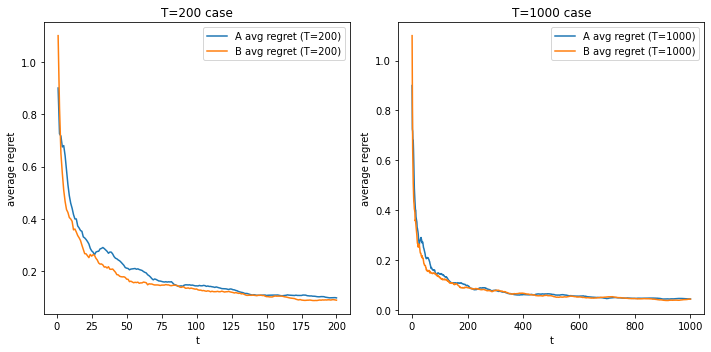

In [48]:
#后悔值的曲线
import random
import math
import statistics
import matplotlib.pyplot as plt

def get_all_strategies(S, N):
    """
    返回所有将 S 个士兵分配到 N 个战场的纯策略列表: (x1,...,xN), sum(xi)=S, xi>=0
    """
    results=[]
    def back(now, left, slots):
        if slots==1:
            results.append(tuple(now+[left]))
            return
        for i in range(left+1):
            back(now+[i], left-i, slots-1)
    back([], S, N)
    return results

def payoff_zero_sum(strategyA, strategyB):
    """
    零和规则: 若 a_i>b_i => (A+=1,B-=1); a_i<b_i => (A-=1,B+=1); a_i=b_i =>(0,0).
    """
    scoreA, scoreB=0,0
    for (a,b) in zip(strategyA, strategyB):
        if a>b:
            scoreA+=1
            scoreB-=1
        elif a<b:
            scoreA-=1
            scoreB+=1
    return scoreA,scoreB

def regret_matching_update(regretSum, allStrats, chosenIndex, oppStrat):
    """
    外部后悔更新: regretSum[j]+= payoff(j, opp)-payoff(chosenIndex, opp).
    """
    chosenStrat = allStrats[chosenIndex]
    scChosen,_= payoff_zero_sum(chosenStrat, oppStrat)
    for j, s_j in enumerate(allStrats):
        sc_j,_= payoff_zero_sum(s_j, oppStrat)
        diff= sc_j-scChosen
        regretSum[j]+=diff
    return regretSum

def get_mixed_strategy(regretSum):
    """
    p[j]=max(0, regret_j)/ sumOfPos
    如果全<=0=>均匀
    """
    pos=[max(0,r) for r in regretSum]
    s=sum(pos)
    n=len(regretSum)
    if s>1e-15:
        return [p/s for p in pos]
    else:
        return [1.0/n]*n

def sample_from_distribution(dist):
    r= random.random()
    cum=0.0
    for i, p in enumerate(dist):
        cum+=p
        if r<cum:
            return i
    return len(dist)-1

def single_run(allStrats, T, seed=None):
    """
    对 A,B 都用后悔匹配, 运行 T 步, 返回每个step的 averageRegretA, averageRegretB
    """
    if seed is not None:
        random.seed(seed)
    m=len(allStrats)
    # A
    regretSumA=[0.0]*m
    cumPayoffA_strat=[0.0]*m  # 对每个j,若一直用它,累积收益
    cumPayoffA_chosen=0.0     # 实际所选策略累积收益
    # B
    regretSumB=[0.0]*m
    cumPayoffB_strat=[0.0]*m
    cumPayoffB_chosen=0.0

    # init
    pA=[1.0/m]*m
    pB=[1.0/m]*m

    regretsA=[]
    regretsB=[]

    for t in range(1, T+1):
        iA= sample_from_distribution(pA)
        iB= sample_from_distribution(pB)

        scA, scB= payoff_zero_sum(allStrats[iA], allStrats[iB])
        # update cum payoff chosen
        cumPayoffA_chosen+=scA
        cumPayoffB_chosen+=scB

        # update each pure payoff
        for j in range(m):
            scAj,_= payoff_zero_sum(allStrats[j], allStrats[iB])
            cumPayoffA_strat[j]+=scAj
        for k in range(m):
            _, scBk= payoff_zero_sum(allStrats[iA], allStrats[k])
            cumPayoffB_strat[k]+=scBk

        # update regrets
        regretSumA= regret_matching_update(regretSumA, allStrats, iA, allStrats[iB])
        regretSumB= regret_matching_update(regretSumB, allStrats, iB, allStrats[iA])

        # get new strategy
        pA= get_mixed_strategy(regretSumA)
        pB= get_mixed_strategy(regretSumB)

        # external regret: max_j(cumPayoffA_strat[j]) - cumPayoffA_chosen
        extA= max(cumPayoffA_strat)- cumPayoffA_chosen
        if extA<0: 
            extA=0
        avgRegretA= extA/t

        extB= max(cumPayoffB_strat)- cumPayoffB_chosen
        if extB<0:
            extB=0
        avgRegretB= extB/t

        regretsA.append(avgRegretA)
        regretsB.append(avgRegretB)

    return regretsA, regretsB

def multiple_runs(allStrats, T, runs=20):
    """
    多次独立运行, 取每个 step 的 average(或median) 以减少随机波动.
    """
    all_regA=[]
    all_regB=[]
    for r in range(runs):
        regA, regB= single_run(allStrats, T, seed=1000+r) 
        all_regA.append(regA)
        all_regB.append(regB)

    # 统计: 对于每个t in [1..T], 求 regA[t], regB[t] 的平均
    avgRegA=[0.0]*T
    avgRegB=[0.0]*T
    for t in range(T):
        valsA=[ all_regA[r][t] for r in range(runs)]
        valsB=[ all_regB[r][t] for r in range(runs)]
        avgRegA[t]= statistics.mean(valsA)
        avgRegB[t]= statistics.mean(valsB)
    return avgRegA, avgRegB

def main():
    N=3
    S=5
    random.seed()
    allStrats= get_all_strategies(S,N)  # 3兵,5场 => C(3+5-1,5-1)=C(7,4)=35
    print(f"Number of pure strategies = {len(allStrats)} (S={S},N={N}).")

    # 分别测试 T=200, T=1000, 甚至更多
    # 同时多次重复 runs=20 或更多, 取平均
    T1=200
    T2=1000
    runs=20

    avgRegA_T1, avgRegB_T1= multiple_runs(allStrats, T1, runs=runs)
    avgRegA_T2, avgRegB_T2= multiple_runs(allStrats, T2, runs=runs)

    # 打印最终时刻(平均后悔)
    print(f"=== T={T1}, after {runs} runs, final avg regret A,B= {avgRegA_T1[-1]:.4f},{avgRegB_T1[-1]:.4f}")
    print(f"=== T={T2}, after {runs} runs, final avg regret A,B= {avgRegA_T2[-1]:.4f},{avgRegB_T2[-1]:.4f}")

    # 也可以做一个log-log图,看看 slope ~ -0.5
    # 这里先做简单可视化:
    plt.figure(figsize=(10,5))

    # 1) plot T=200
    plt.subplot(1,2,1)
    plt.plot(range(1,T1+1), avgRegA_T1, label='A avg regret (T=200)')
    plt.plot(range(1,T1+1), avgRegB_T1, label='B avg regret (T=200)')
    plt.xlabel('t')
    plt.ylabel('average regret')
    plt.title('T=200 case')
    plt.legend()

    # 2) plot T=1000
    plt.subplot(1,2,2)
    plt.plot(range(1,T2+1), avgRegA_T2, label='A avg regret (T=1000)')
    plt.plot(range(1,T2+1), avgRegB_T2, label='B avg regret (T=1000)')
    plt.xlabel('t')
    plt.ylabel('average regret')
    plt.title('T=1000 case')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__=="__main__":
    main()


Number of pure strategies= 21 for (S=5,N=3).

=== Observing average regrets at specified time steps ===

  t=2,  avg_regA=0.75000, avg_regB=0.80000
  t=4,  avg_regA=0.51250, avg_regB=0.61250
  t=8,  avg_regA=0.39375, avg_regB=0.48125
  t=16,  avg_regA=0.26250, avg_regB=0.35938
  t=32,  avg_regA=0.20625, avg_regB=0.25781
  t=64,  avg_regA=0.17578, avg_regB=0.18984
  t=128,  avg_regA=0.12227, avg_regB=0.12148
  t=256,  avg_regA=0.08105, avg_regB=0.10000
  t=512,  avg_regA=0.05752, avg_regB=0.05742
  t=1024,  avg_regA=0.03672, avg_regB=0.03872
  t=2048,  avg_regA=0.02473, avg_regB=0.02688
  t=4096,  avg_regA=0.01793, avg_regB=0.01731



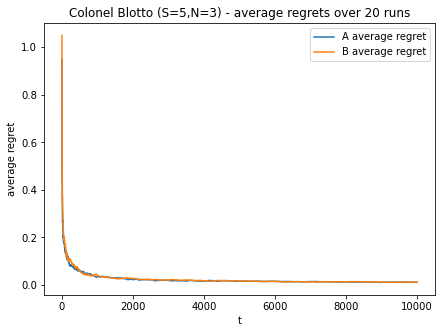

In [52]:
#展示后悔值验证收敛
import random, math, statistics
import matplotlib.pyplot as plt

def get_all_strategies(S, N):
    """
    枚举所有将 S 个兵力分配到 N 个战场的纯策略列表。
    (x1, x2, ..., xN)，xi >= 0, sum(xi)=S。
    对 (S=5, N=3), 大小= C(5+3-1, 3-1)= C(7,2)=21.
    """
    results=[]
    def back(now, left, slots):
        if slots==1:
            results.append(tuple(now+[left]))
            return
        for i in range(left+1):
            back(now+[i], left-i, slots-1)
    back([], S, N)
    return results

def payoff_zero_sum(strategyA, strategyB):
    """
    零和计分:
      if a>b => (A+=1,B-=1)
      if a<b => (A-=1,B+=1)
      if a=b => (0,0)
    3个战场加和 => (scoreA, scoreB).
    """
    scoreA=0
    scoreB=0
    for a,b in zip(strategyA, strategyB):
        if a>b:
            scoreA+=1
            scoreB-=1
        elif a<b:
            scoreA-=1
            scoreB+=1
    return scoreA, scoreB

def regret_update(regretSum, allStrats, chosenIndex, oppStrat):
    """
    外部后悔: regretSum[j]+= payoff(j,opp)- payoff(chosenIndex, opp)
    """
    chosenStrat= allStrats[chosenIndex]
    scChosen,_= payoff_zero_sum(chosenStrat, oppStrat)
    for j, s_j in enumerate(allStrats):
        sc_j,_= payoff_zero_sum(s_j, oppStrat)
        diff= sc_j- scChosen
        regretSum[j]+= diff
    return regretSum

def get_mixed_strategy(regretSum):
    """
    p[j] = max(0, regret_j)/ sum_of_positives
    若 sum_of_positives=0 => 均匀
    """
    pos= [max(0.0,r) for r in regretSum]
    s= sum(pos)
    n= len(regretSum)
    if s>1e-15:
        return [p/s for p in pos]
    else:
        return [1.0/n]*n

def sample_from_distribution(dist):
    r= random.random()
    cum=0.0
    for i,p in enumerate(dist):
        cum+=p
        if r<cum:
            return i
    return len(dist)-1

def single_run(allStrats, T, seed=None):
    """
    进行一次完整的后悔匹配对战(A,B都学习), 到 T 步:
    返回 regretsA[t], regretsB[t], 其中 regretsA[t] 是时刻 t 的 平均后悔(0-based)
    """
    if seed is not None:
        random.seed(seed)
    m= len(allStrats)

    random.seed()
    # 对 A
    regretSumA= [0.0]*m
    cumPayoffA_strat= [0.0]*m
    cumPayoffA_chosen=0.0

    # 对 B
    regretSumB= [0.0]*m
    cumPayoffB_strat= [0.0]*m
    cumPayoffB_chosen=0.0

    # 初始化混合策略
    pA= [1.0/m]*m
    pB= [1.0/m]*m

    regretsA= []
    regretsB= []

    for t in range(1,T+1):
        iA= sample_from_distribution(pA)
        iB= sample_from_distribution(pB)

        scA, scB= payoff_zero_sum(allStrats[iA], allStrats[iB])
        # 累积实际收益
        cumPayoffA_chosen+= scA
        cumPayoffB_chosen+= scB

        # 更新 "若一直用 j" 收益
        for j in range(m):
            scAj,_= payoff_zero_sum(allStrats[j], allStrats[iB])
            cumPayoffA_strat[j]+= scAj
        for k in range(m):
            _, scBk= payoff_zero_sum(allStrats[iA], allStrats[k])
            cumPayoffB_strat[k]+= scBk

        # 后悔更新
        regretSumA= regret_update(regretSumA, allStrats, iA, allStrats[iB])
        regretSumB= regret_update(regretSumB, allStrats, iB, allStrats[iA])
        # 得到新混合策略
        pA= get_mixed_strategy(regretSumA)
        pB= get_mixed_strategy(regretSumB)

        # 计算外部后悔
        bestA= max(cumPayoffA_strat)
        extA= bestA - cumPayoffA_chosen
        if extA<0: extA=0
        avgA= extA/t

        bestB= max(cumPayoffB_strat)
        extB= bestB - cumPayoffB_chosen
        if extB<0: extB=0
        avgB= extB/t

        regretsA.append(avgA)
        regretsB.append(avgB)

    return regretsA, regretsB

def multi_runs_observe(allStrats, T, runs=20, seeds=None):
    """
    多次独立运行, 返回:
      avgRegA[t], avgRegB[t], 其中每个 t 的外部后悔取所有 runs 的平均
    """
    if seeds is None:
        seeds= [1000+i for i in range(runs)]
    all_regA= []
    all_regB= []
    for r in range(runs):
        regA, regB= single_run(allStrats, T, seed=seeds[r])
        all_regA.append(regA)
        all_regB.append(regB)

    # 对每个 t, 取 average
    avgRegA= []
    avgRegB= []
    for t in range(T):
        valsA= [all_regA[r][t] for r in range(runs)]
        valsB= [all_regB[r][t] for r in range(runs)]
        avgRegA.append( statistics.mean(valsA) )
        avgRegB.append( statistics.mean(valsB) )
    return avgRegA, avgRegB

def main():
    S, N= 5, 3
    allStrats= get_all_strategies(S,N)
    print(f"Number of pure strategies= {len(allStrats)} for (S={S},N={N}).")

    # 要观测在 t=10,100,500,1000,5000,10000 的平均后悔:
    # 先把 maxT=10000 全都跑完, 每个 step 记录. 再在指定点输出
    Tmax=10000
    runs= 20   # 多次重复
    avgRegA, avgRegB= multi_runs_observe(allStrats, Tmax, runs=runs)

    # 观察点
    check_points= [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
    print("\n=== Observing average regrets at specified time steps ===\n")
    for cp in check_points:
        rA= avgRegA[cp-1]   # 0-based index
        rB= avgRegB[cp-1]
        print(f"  t={cp},  avg_regA={rA:.5f}, avg_regB={rB:.5f}")
    print()

    # 如果想画图，也可以一并展示
    plt.figure(figsize=(7,5))
    plt.plot(range(1,Tmax+1), avgRegA, label='A average regret')
    plt.plot(range(1,Tmax+1), avgRegB, label='B average regret')
    plt.xlabel('t')
    plt.ylabel('average regret')
    plt.title(f'Colonel Blotto (S=5,N=3) - average regrets over {runs} runs')
    plt.legend()
    plt.show()

if __name__=="__main__":
    main()
